In [ ]:
import importlib
import subprocess
import sys

def ensure_package_installed(package_name):
    try:
        importlib.import_module(package_name)
        print(f"✅ Package '{package_name}' is already installed.")
    except ImportError:
        print(f"📦 Installing package: {package_name}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])

ensure_package_installed("arch")
ensure_package_installed("wbdata")

✅ Package 'arch' is already installed.
✅ Package 'wbdata' is already installed.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

# 1. Chargement et nettoyage des données
# Remplacez 'brvm_data.csv' par le chemin de votre fichier CSV
df = pd.read_csv('boab.csv', parse_dates=['Date'], dayfirst=True)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

# 1. Chargement et nettoyage des données
# Remplacez 'brvm_data.csv' par le chemin de votre fichier CSV
df = pd.read_csv('boab.csv', parse_dates=['Date'], dayfirst=True)

# Conversion de la colonne 'Vol.' (ex. '3,68K' -> 3680)
def convert_volume(vol):
    if isinstance(vol, str):
        vol = vol.replace(',', '.').replace('K', 'e3')
        return float(vol)
    return vol

df['Vol.'] = df['Vol.'].apply(convert_volume)

cols_to_multiply = ['Dernier', 'Ouv.', ' Plus Haut', 'Plus Bas']

df[cols_to_multiply] = df[cols_to_multiply].apply(lambda x: x * 100)

# Conversion de 'Variation %' en float (ex. '1,71%' -> 1.71)
df['Variation %'] = df['Variation %'].str.replace(',', '.').str.rstrip('%').astype(float)

# Tri des données par date (du plus ancien au plus récent)
df = df.sort_values('Date').set_index('Date')

# 2. Calcul des rendements logarithmiques
df['Returns'] = 100 * np.log(df['Dernier'] / df['Dernier'].shift(1))
df = df.dropna()  # Supprimer les valeurs manquantes

In [ ]:
df.head()

,Dernier,Ouv.,Plus Haut,Plus Bas,Vol.,Variation %,Returns
Date,,,,,,,
2014-04-28,6500.0,6500.0,6500.0,6500.0,0.0,0.0,0.0
2014-04-29,6500.0,6500.0,6500.0,6500.0,10.0,0.0,0.0
2014-05-05,6500.0,6500.0,6500.0,6500.0,20.0,0.0,0.0
2014-05-07,6500.0,6500.0,6500.0,6500.0,10.0,0.0,0.0
2014-05-14,6500.0,6500.0,6500.0,6500.0,20.0,0.0,0.0


In [ ]:
display(df)

,Dernier,Ouv.,Plus Haut,Plus Bas,Vol.,Variation %,Returns
Date,,,,,,,
2014-04-28,6500.0,6500.0,6500.0,6500.0,0.0,0.00,0.000000
2014-04-29,6500.0,6500.0,6500.0,6500.0,10.0,0.00,0.000000
2014-05-05,6500.0,6500.0,6500.0,6500.0,20.0,0.00,0.000000
2014-05-07,6500.0,6500.0,6500.0,6500.0,10.0,0.00,0.000000
2014-05-14,6500.0,6500.0,6500.0,6500.0,20.0,0.00,0.000000
...,...,...,...,...,...,...,...
2025-08-19,444.5,440.0,444.5,440.0,440.0,1.02,1.017533
2025-08-20,447.0,444.5,447.0,444.5,3520.0,0.56,0.560854
2025-08-21,449.5,447.0,449.5,447.0,2510.0,0.56,0.557726


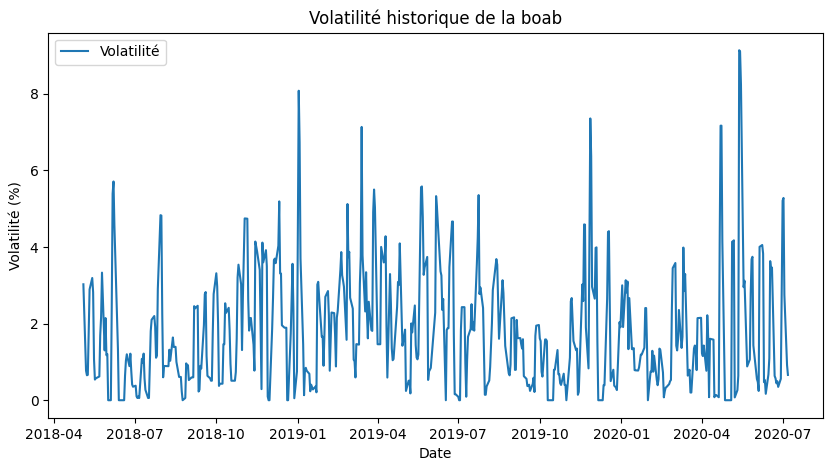

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Dates de début et fin (en datetime)
start_date = pd.to_datetime('2018-05-01')
end_date = pd.to_datetime('2020-07-07')

# Si 'Date' est index, remettons-le en colonne
df_reset = df.reset_index()

# Filtrage sur la période choisie
mask = (df_reset['Date'] >= start_date) & (df_reset['Date'] <= end_date)
df_period = df_reset.loc[mask].copy()

# Vérification que df_period n'est pas vide
if df_period.empty:
    print("Aucune donnée disponible dans cette période.")
else:
    # Calcul volatilité sur 3 observations (adapté à petite période)
    window_size = 3
    df_period['Volatilite'] = df_period['Returns'].rolling(window=window_size).std()

    # Passage en index datetime pour rolling temporel
    df_period.set_index('Date', inplace=True)

    # Graphique
    plt.figure(figsize=(10, 5))
    plt.plot(df_period['Volatilite'], label=f'Volatilité')
    plt.title("Volatilité historique de la boab")
    plt.xlabel('Date')
    plt.ylabel('Volatilité (%)')
    plt.legend()
    plt.grid(False)
    plt.show()

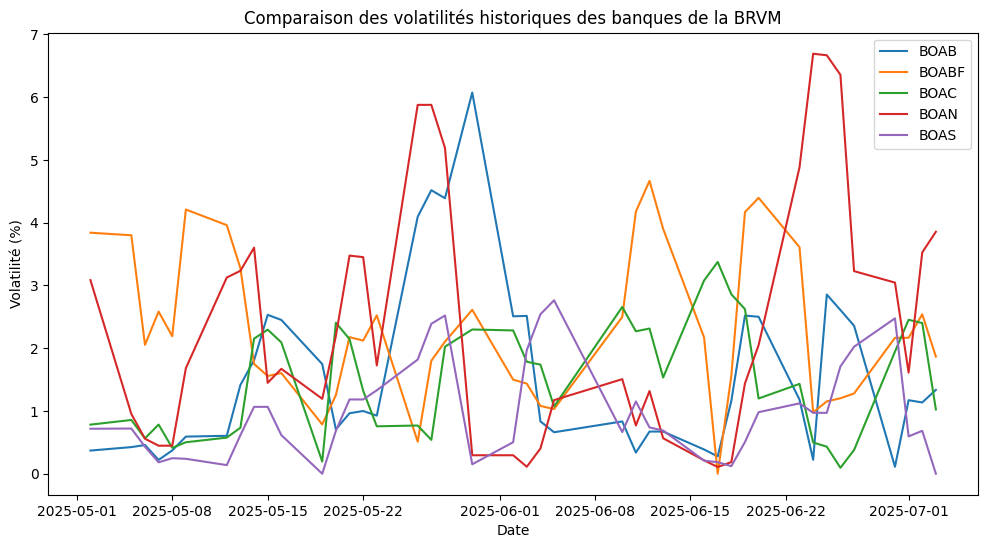

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Fonction pour charger, nettoyer et calculer volatilité d'une base
def process_bank_data(file_path, start_date, end_date, window_size=3):
    df2 = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)
    df2 = df2.set_index('Date')
    # Calcul des rendements log
    df2['Returns'] = 100 * (np.log(df2['Dernier'] / df2['Dernier'].shift(1)))
    df2 = df2.dropna(subset=['Returns'])

    cols_to_multiply = ['Dernier', 'Ouv.', ' Plus Haut', 'Plus Bas']

    df2[cols_to_multiply] = df2[cols_to_multiply].apply(lambda x: x * 100)

    # Filtrage période
    df_period = df2.loc[(df2.index >= start_date) & (df2.index <= end_date)].copy()

    # Calcul volatilité rolling
    df_period['Volatilite'] = df_period['Returns'].rolling(window=window_size).std()

    return df_period['Volatilite']

# Dates de la période
start_date = pd.to_datetime('2025-05-01')
end_date = pd.to_datetime('2025-07-07')

# Liste des fichiers et leurs noms pour la légende
banks_files = {
    'BOAB': 'boab.csv',
    'BOABF': 'boabf.csv',
    'BOAC': 'boac.csv',
    'BOAN': 'boan.csv',
    'BOAS': 'boas.csv'
}

plt.figure(figsize=(12, 6))

for bank_name, file_path in banks_files.items():
    vol = process_bank_data(file_path, start_date, end_date)
    plt.plot(vol.index, vol, label=bank_name)

plt.title('Comparaison des volatilités historiques des banques de la BRVM')
plt.xlabel('Date')
plt.ylabel('Volatilité (%)')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
import wbdata
import pandas as pd
import datetime

start_date = datetime.datetime(1960, 1, 1)
end_date = datetime.datetime(2026, 1, 1)

indicators = {
    'FP.CPI.TOTL.ZG': 'Inflation CPI (%)',
    'NY.GDP.MKTP.KD.ZG': 'Croissance PIB réel (%)',
    'PA.NUS.FCRF': 'Taux de change officiel'
}

country = 'BEN'

# Télécharger les données sans filtre date
df1 = wbdata.get_dataframe(indicators, country=country)

# Convertir index en datetime
df1.index = pd.to_datetime(df1.index)

# Filtrer les dates
df_filtered = df1.loc[(df1.index >= start_date) & (df1.index <= end_date)]

# Remettre l’index (date) en colonne "date"
df_filtered = df_filtered.reset_index()

# Renommer les colonnes
df_filtered.rename(columns={
    'date': 'Annee',
    'Inflation CPI (%)': 'Inflation',
    'Croissance PIB réel (%)': 'Croissance_PIB',
    'Taux de change officiel': 'Taux_change'
}, inplace=True)

print(df_filtered.head())

# Exporter CSV sans index
df_filtered.to_csv("macro.csv", index=False)

       Annee  Inflation  Croissance_PIB  Taux_change
0 2024-01-01   1.160931        7.453116   606.345298
1 2023-01-01   2.738701        6.352777   606.654982
2 2022-01-01   1.350779        6.252947   622.912348
3 2021-01-01   1.733540        7.155452   554.607799
4 2020-01-01   3.022721        3.848792   574.294550


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Chargement et nettoyage des données
df1 = pd.read_csv('macro.csv')

# Nettoyage des espaces insécables dans les noms de colonnes
df1.columns = df1.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Vérifier que ça fonctionne
print(df1.head())
print(df1.columns.tolist())

# Convertir 'Annee' en datetime puis extraire l'année en entier
df1['Annee'] = pd.to_datetime(df1['Annee'].astype(str).str.strip()).dt.year

# Supprimer les lignes avec valeurs manquantes dans les colonnes à tracer
df_clean = df1.dropna(subset=['Inflation', 'Croissance_PIB', 'Taux_change'])
print(df_clean.head())

        Annee  Inflation  Croissance_PIB  Taux_change
0  2024-01-01   1.160931        7.453116   606.345298
1  2023-01-01   2.738701        6.352777   606.654982
2  2022-01-01   1.350779        6.252947   622.912348
3  2021-01-01   1.733540        7.155452   554.607799
4  2020-01-01   3.022721        3.848792   574.294550
['Annee', 'Inflation', 'Croissance_PIB', 'Taux_change']
   Annee  Inflation  Croissance_PIB  Taux_change
0   2024   1.160931        7.453116   606.345298
1   2023   2.738701        6.352777   606.654982
2   2022   1.350779        6.252947   622.912348
3   2021   1.733540        7.155452   554.607799
4   2020   3.022721        3.848792   574.294550


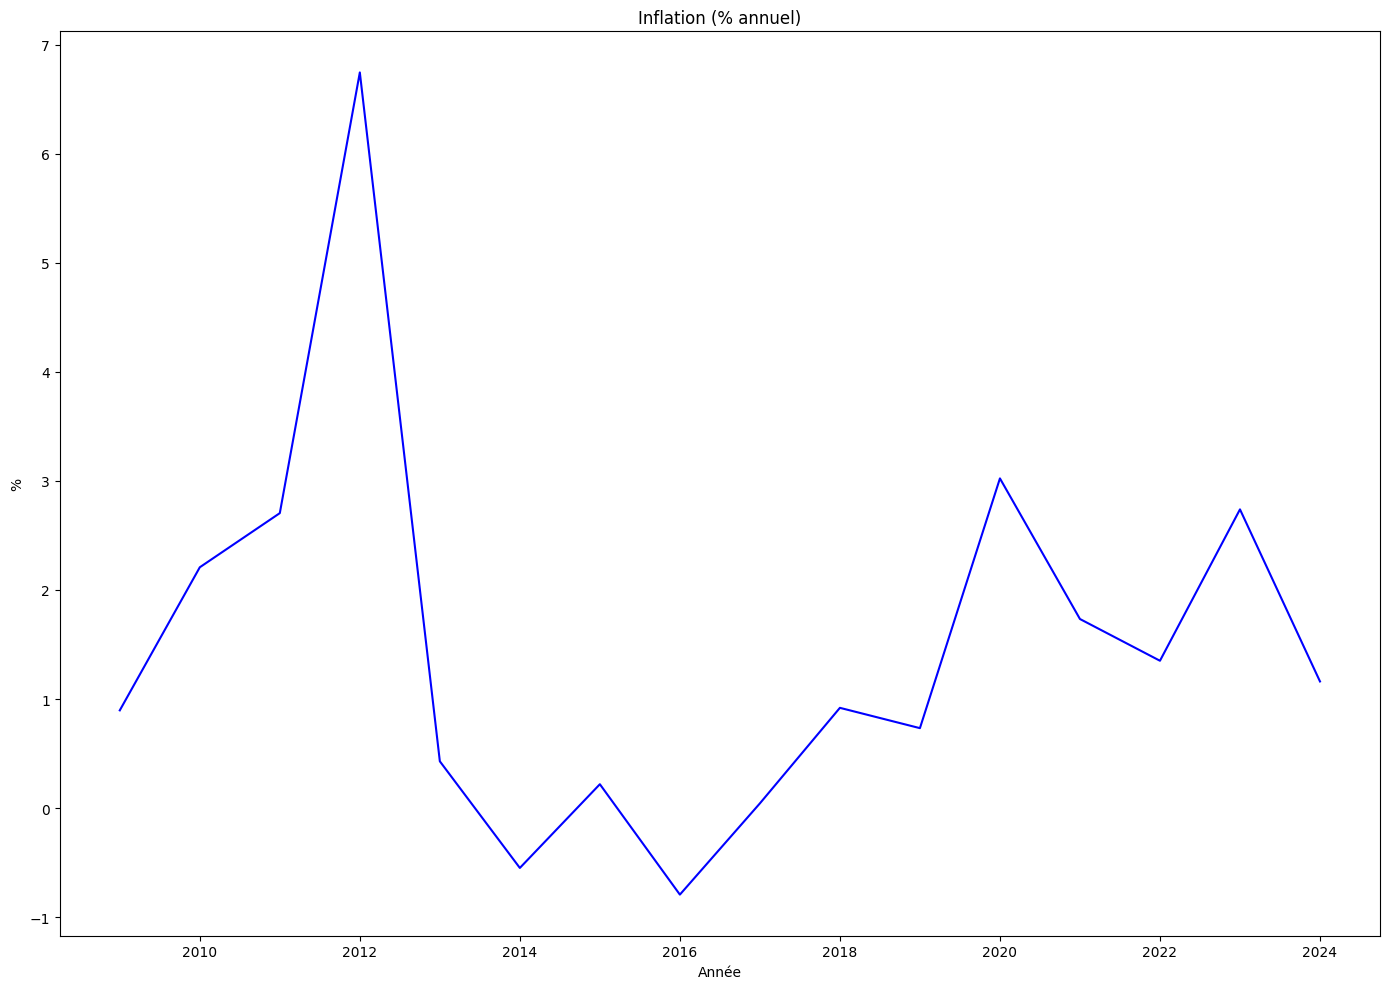

In [ ]:
# Inflation
plt.figure(figsize=(14, 10))
plt.plot(df_clean['Annee'], df_clean['Inflation'], color='blue')
plt.title('Inflation (% annuel)')
plt.xlabel('Année')
plt.ylabel('%')
plt.grid(False)
plt.tight_layout()
plt.show()

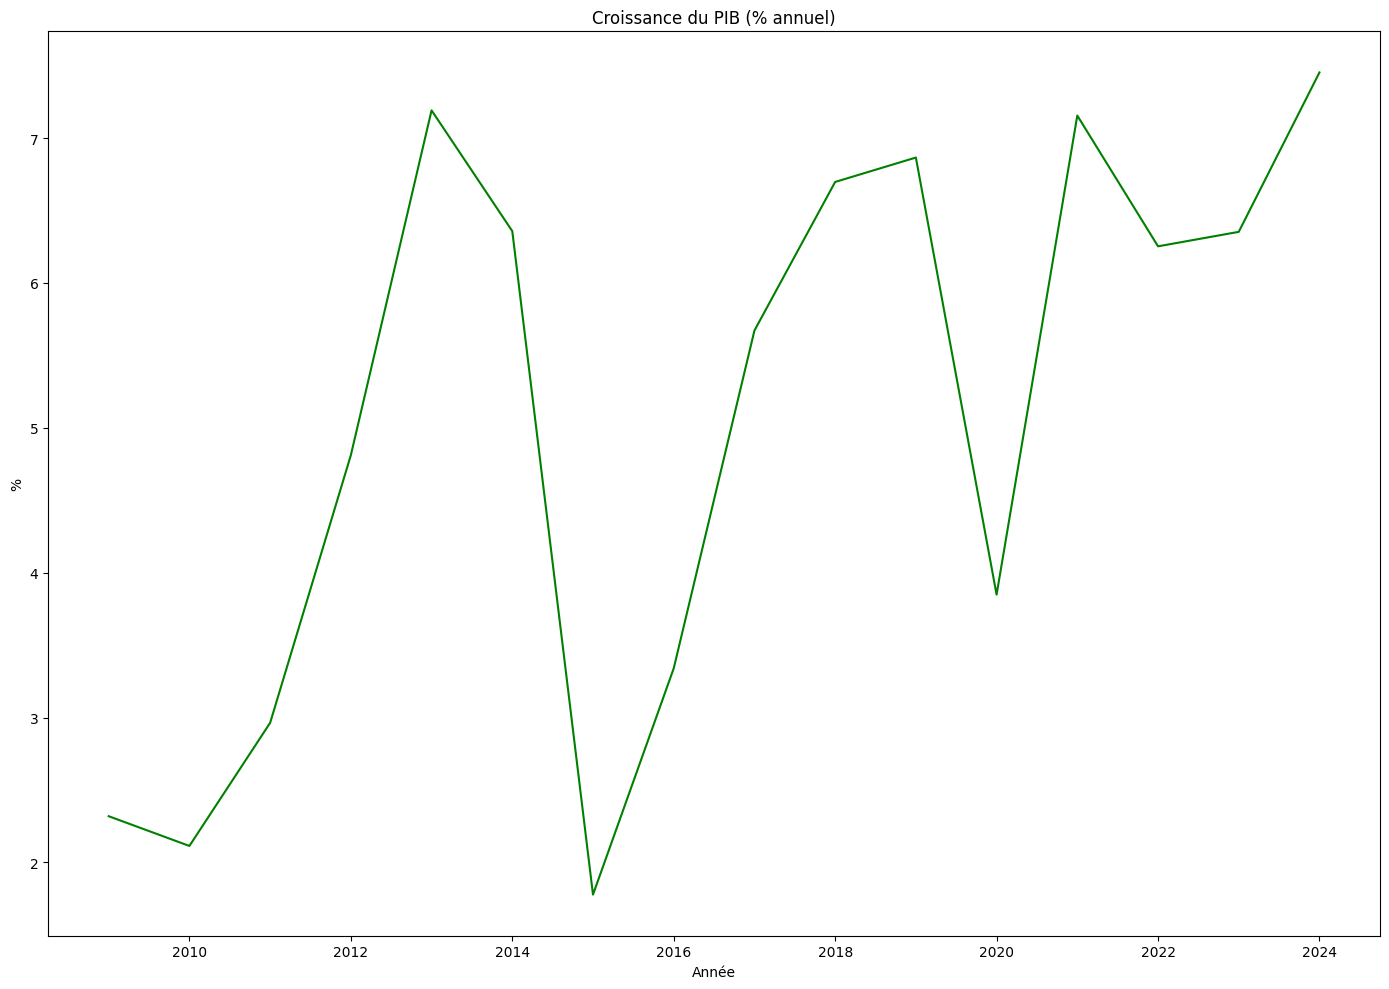

In [ ]:
# Croissance du PIB
plt.figure(figsize=(14, 10))
plt.plot(df_clean['Annee'], df_clean['Croissance_PIB'], color='green')
plt.title('Croissance du PIB (% annuel)')
plt.xlabel('Année')
plt.ylabel('%')
plt.grid(False)
plt.tight_layout()
plt.show()

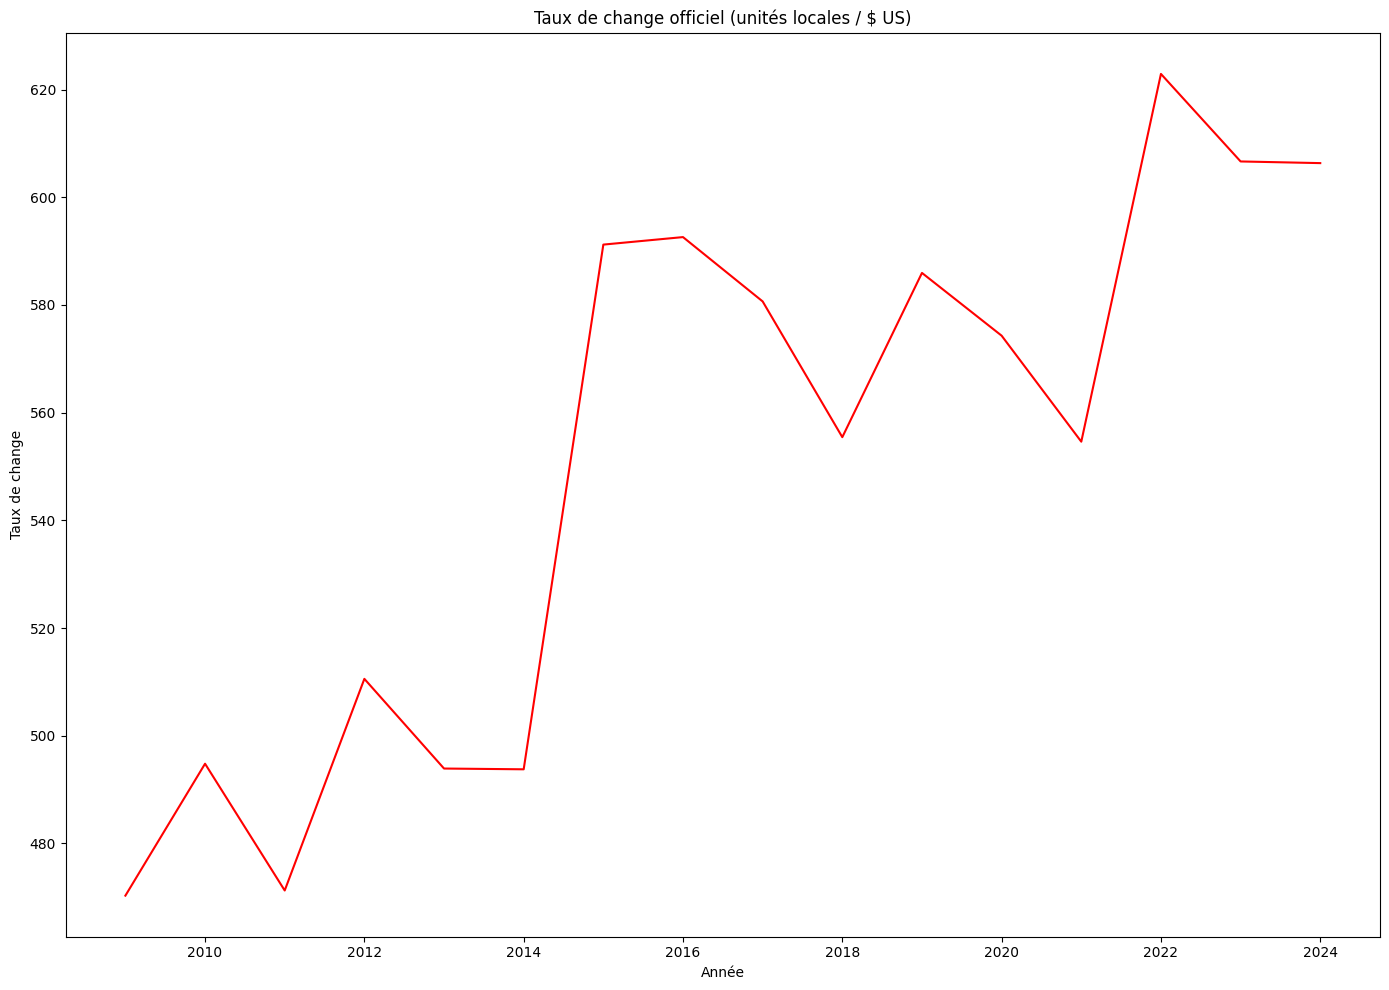

In [ ]:
# Taux de change officiel
plt.figure(figsize=(14, 10))
plt.plot(df_clean['Annee'], df_clean['Taux_change'], color='red')
plt.title('Taux de change officiel (unités locales / $ US)')
plt.xlabel('Année')
plt.ylabel('Taux de change')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
print(df_reset.columns)

Index(['Date', 'Dernier', 'Ouv.', ' Plus Haut', 'Plus Bas', 'Vol.',
       'Variation %', 'Returns'],
      dtype='object')


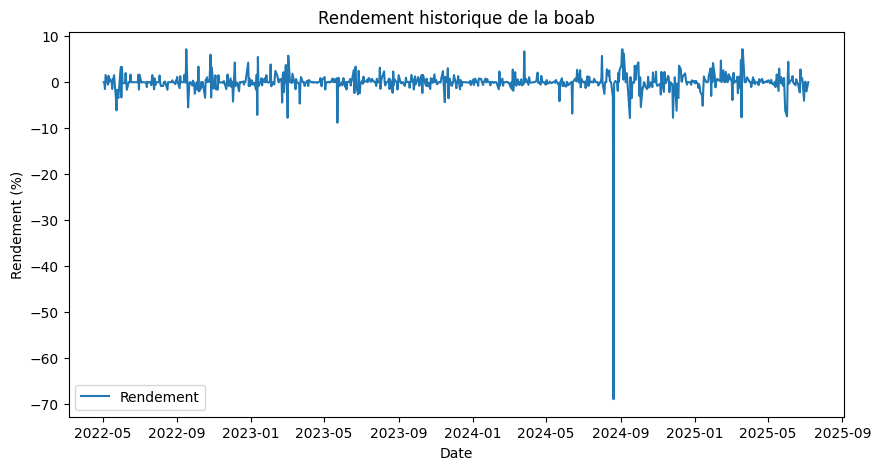

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dates de début et fin (en datetime)
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2025-07-07')

# Remettre Date en colonne si besoin
df_reset = df.reset_index()

# Calcul des rendements logarithmiques si pas déjà fait
if 'Returns' not in df_reset.columns:
    df_reset['Returns'] = 100 * np.log(df_reset['Dernier'] / df_reset['Dernier'].shift(1))

# Filtrer la période
mask = (df_reset['Date'] >= start_date) & (df_reset['Date'] <= end_date)
df_period = df_reset.loc[mask].copy()

# Supprimer les NaN éventuels dans Returns
df_period = df_period.dropna(subset=['Returns'])

if df_period.empty:
    print("Aucune donnée disponible dans cette période.")
else:
    # Passer Date en index pour tracer
    df_period = df_period.set_index('Date')

    # Tracer le rendement
    plt.figure(figsize=(10, 5))
    plt.plot(df_period['Returns'], label='Rendement')
    plt.title("Rendement historique de la boab")
    plt.xlabel('Date')
    plt.ylabel('Rendement (%)')
    plt.legend()
    plt.grid(False)
    plt.show()

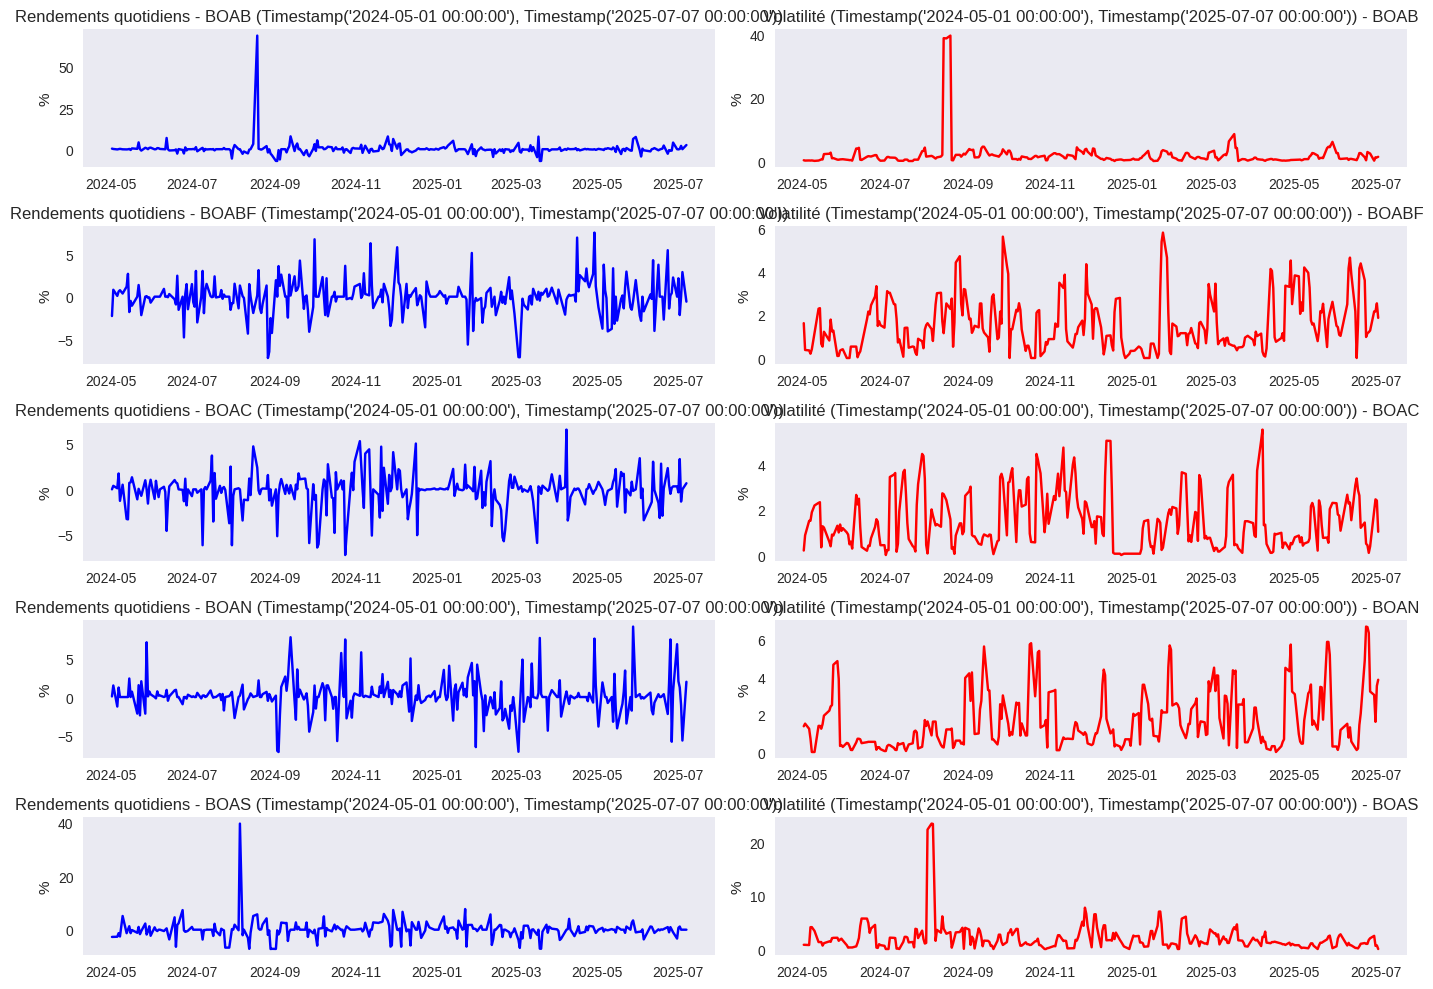

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fonction modifiée pour retourner aussi les rendements et la volatilité
def process_bank_data(file_path, start_date, end_date, window_size=3):
    df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)
    df = df.set_index('Date')

    # Calcul des rendements logarithmiques en %
    df['Returns'] = 100 * np.log(df['Dernier'] / df['Dernier'].shift(1))
    df = df.dropna(subset=['Returns'])

    # Filtrer la période
    df_period = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()

    # Calcul de la volatilité rolling
    df_period['Volatilite'] = df_period['Returns'].rolling(window=window_size).std()

    return df_period[['Returns', 'Volatilite']]

# Période d'analyse
start_date = pd.to_datetime('2024-05-01')
end_date = pd.to_datetime('2025-07-07')

banks_files = {
    'BOAB': 'boab.csv',
    'BOABF': 'boabf.csv',
    'BOAC': 'boac.csv',
    'BOAN': 'boan.csv',
    'BOAS': 'boas.csv'
}

plt.figure(figsize=(14, 10))

for i, (bank_name, file_path) in enumerate(banks_files.items(), start=1):
    data = process_bank_data(file_path, start_date, end_date)

    # Rendements
    plt.subplot(len(banks_files), 2, 2*i - 1)
    plt.plot(data.index, data['Returns'], label=f'Rendements {bank_name}', color='blue')
    plt.ylabel('%')
    plt.title(f'Rendements quotidiens - {bank_name} {start_date,end_date}')
    plt.grid(False)

    # Volatilité
    plt.subplot(len(banks_files), 2, 2*i)
    plt.plot(data.index, data['Volatilite'], label=f'Volatilité {bank_name}', color='red')
    plt.ylabel('%')
    plt.title(f'Volatilité {start_date,end_date} - {bank_name}')
    plt.grid(False)

plt.tight_layout()
plt.show()

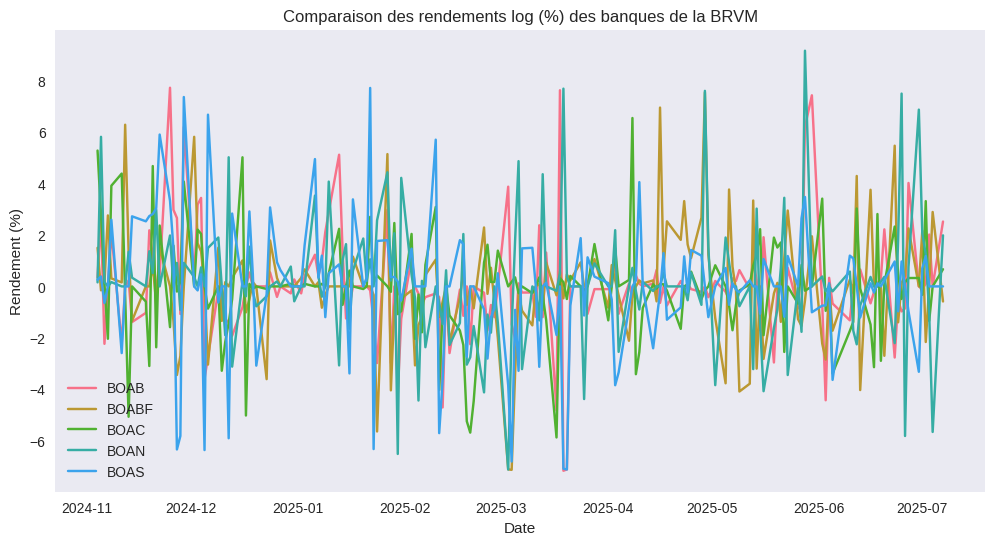

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour charger, nettoyer et calculer rendements d'une base
def process_bank_returns(file_path, start_date, end_date):
    df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)
    df = df.set_index('Date')

    # Calcul des rendements logarithmiques en pourcentage
    df['Returns'] = 100 * (np.log(df['Dernier'] / df['Dernier'].shift(1)))
    df = df.dropna(subset=['Returns'])

    # Filtrage période
    df_period = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()

    return df_period['Returns']

# Dates de la période
start_date = pd.to_datetime('2024-11-01')
end_date = pd.to_datetime('2025-07-07')

# Liste des fichiers et leurs noms pour la légende
banks_files = {
    'BOAB': 'boab.csv',
    'BOABF': 'boabf.csv',
    'BOAC': 'boac.csv',
    'BOAN': 'boan.csv',
    'BOAS': 'boas.csv'
}

plt.figure(figsize=(12, 6))

for bank_name, file_path in banks_files.items():
    returns = process_bank_returns(file_path, start_date, end_date)
    plt.plot(returns.index, returns, label=bank_name)

plt.title('Comparaison des rendements log (%) des banques de la BRVM')
plt.xlabel('Date')
plt.ylabel('Rendement (%)')
plt.legend()
plt.grid(False)
plt.show()

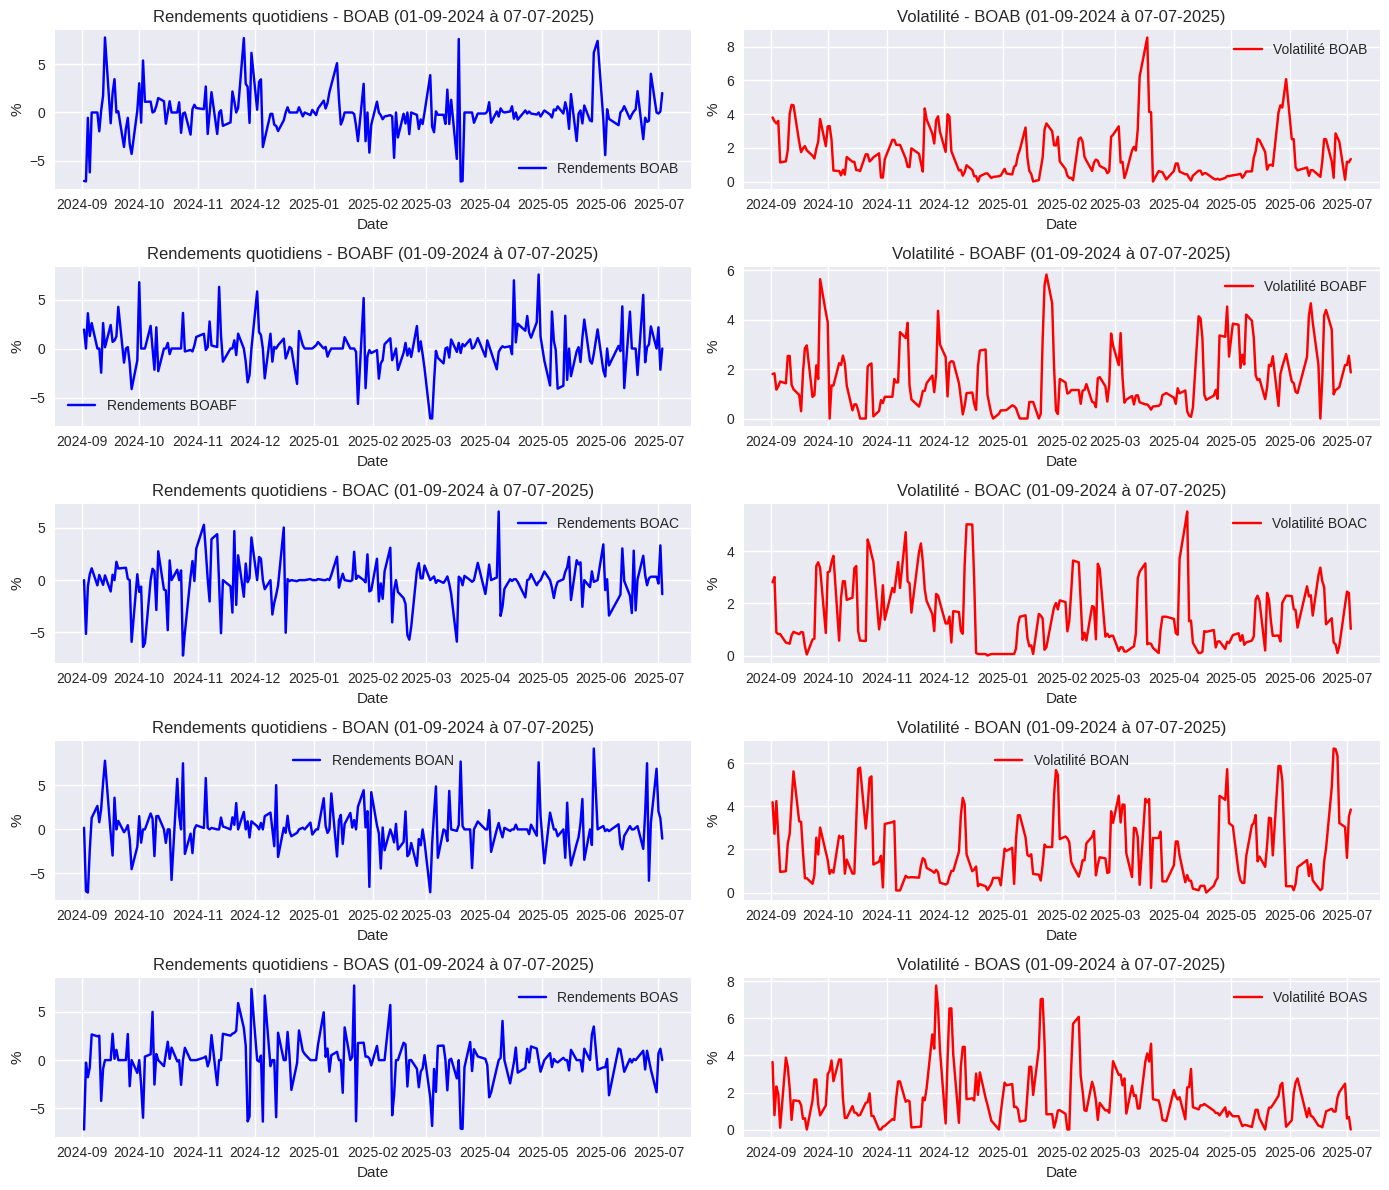

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def process_bank_data(file_path, start_date, end_date, window_size=3):
    df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)
    df = df.set_index('Date')

    # Calcul des rendements logarithmiques en %
    df['Returns'] = 100 * np.log(df['Dernier'] / df['Dernier'].shift(1))
    df = df.dropna(subset=['Returns'])

    # Filtrer la période
    df_period = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()

    # Calcul de la volatilité rolling
    df_period['Volatilite'] = df_period['Returns'].rolling(window=window_size).std()

    # Supprimer les NaN de la volatilité (dus au rolling)
    df_period = df_period.dropna(subset=['Volatilite'])

    return df_period[['Returns', 'Volatilite']]

# Période d'analyse
start_date = pd.to_datetime('2024-09-01')
end_date = pd.to_datetime('2025-07-07')

banks_files = {
    'BOAB': 'boab.csv',
    'BOABF': 'boabf.csv',
    'BOAC': 'boac.csv',
    'BOAN': 'boan.csv',
    'BOAS': 'boas.csv'
}

plt.figure(figsize=(14, 12))

for i, (bank_name, file_path) in enumerate(banks_files.items(), start=1):
    try:
        data = process_bank_data(file_path, start_date, end_date)

        # Format dates pour titre
        date_str = f"{start_date.strftime('%d-%m-%Y')} à {end_date.strftime('%d-%m-%Y')}"

        # Rendements
        plt.subplot(len(banks_files), 2, 2*i - 1)
        plt.plot(data.index, data['Returns'], label=f'Rendements {bank_name}', color='blue')
        plt.ylabel('%')
        plt.xlabel('Date')
        plt.title(f'Rendements quotidiens - {bank_name} ({date_str})')
        plt.grid(True)
        plt.legend()

        # Volatilité
        plt.subplot(len(banks_files), 2, 2*i)
        plt.plot(data.index, data['Volatilite'], label=f'Volatilité {bank_name}', color='red')
        plt.ylabel('%')
        plt.xlabel('Date')
        plt.title(f'Volatilité - {bank_name} ({date_str})')
        plt.grid(True)
        plt.legend()

    except Exception as e:
        print(f"Erreur avec le fichier {file_path} ({bank_name}): {e}")

plt.tight_layout()
plt.show()

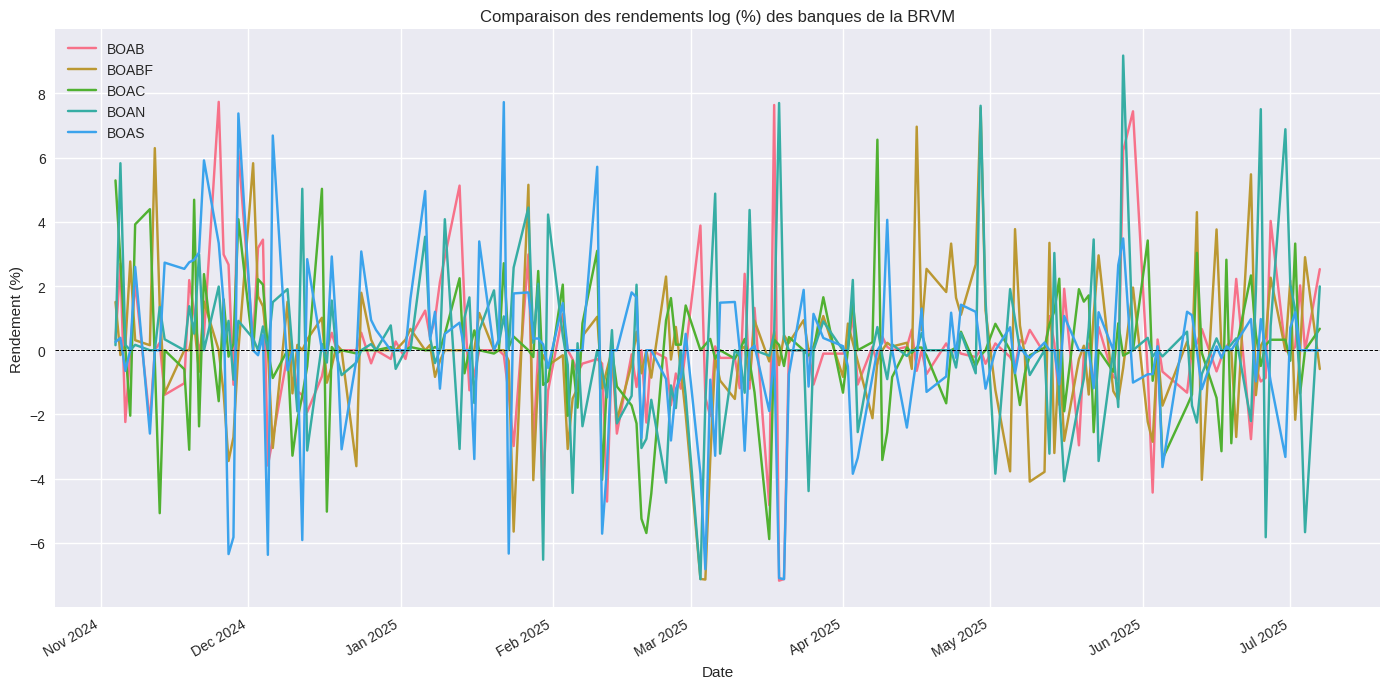

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Fonction pour charger, nettoyer et calculer rendements d'une base
def process_bank_returns(file_path, start_date, end_date):
    df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)
    df = df.set_index('Date')

    # Calcul des rendements logarithmiques en pourcentage
    df['Returns'] = 100 * (np.log(df['Dernier'] / df['Dernier'].shift(1)))
    df = df.dropna(subset=['Returns'])

    # Filtrage période
    df_period = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()

    return df_period['Returns']

# Dates de la période
start_date = pd.to_datetime('2024-11-01')
end_date = pd.to_datetime('2025-07-07')

# Liste des fichiers et leurs noms pour la légende
banks_files = {
    'BOAB': 'boab.csv',
    'BOABF': 'boabf.csv',
    'BOAC': 'boac.csv',
    'BOAN': 'boan.csv',
    'BOAS': 'boas.csv'
}

plt.figure(figsize=(14, 7))

for bank_name, file_path in banks_files.items():
    returns = process_bank_returns(file_path, start_date, end_date)
    plt.plot(returns.index, returns, label=bank_name)

plt.title('Comparaison des rendements log (%) des banques de la BRVM')
plt.xlabel('Date')
plt.ylabel('Rendement (%)')

plt.axhline(0, color='black', linestyle='--', linewidth=0.7)

plt.legend()
plt.grid(True)

# Formatage des dates sur l'axe X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()  # Rotation automatique des dates

plt.tight_layout()
plt.show()

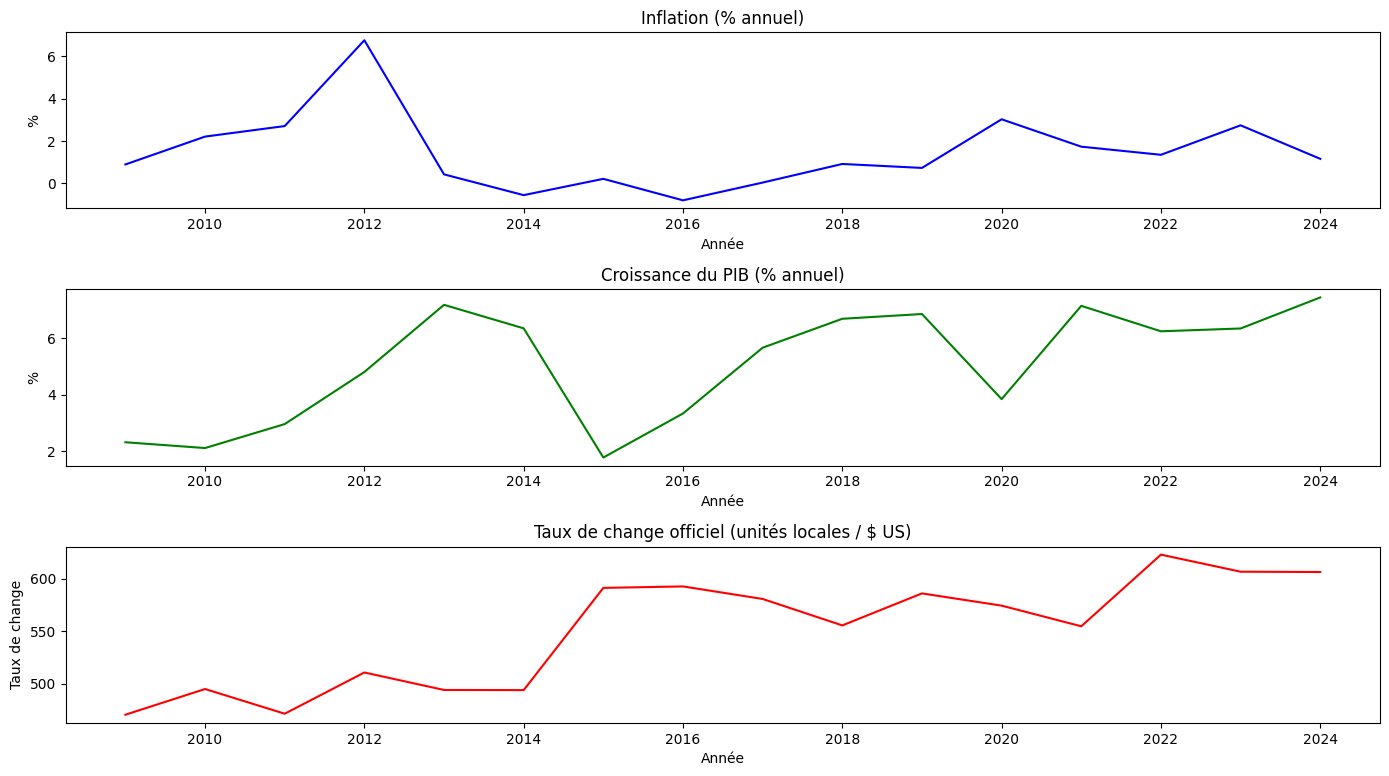

In [ ]:
import matplotlib.pyplot as plt

# Supposons que df1 est déjà chargé et que les colonnes ont été renommées comme discuté

# S'assurer que 'Annee' est numérique
df1['Annee'] = pd.to_numeric(df1['Annee'], errors='coerce')

# Supprimer les lignes avec valeurs manquantes dans les colonnes à tracer
df_clean = df1.dropna(subset=['Inflation', 'Croissance_PIB', 'Taux_change'])

plt.figure(figsize=(14, 10))

# Inflation
plt.subplot(4, 1, 1)
plt.plot(df_clean['Annee'], df_clean['Inflation'], color='blue')
plt.title('Inflation (% annuel)')
plt.xlabel('Année')
plt.ylabel('%')
plt.grid(False)

# Croissance du PIB
plt.subplot(4, 1, 2)
plt.plot(df_clean['Annee'], df_clean['Croissance_PIB'], color='green')
plt.title('Croissance du PIB (% annuel)')
plt.xlabel('Année')
plt.ylabel('%')
plt.grid(False)

# Taux de change officiel
plt.subplot(4, 1, 3)
plt.plot(df_clean['Annee'], df_clean['Taux_change'], color='red')
plt.title('Taux de change officiel (unités locales / $ US)')
plt.xlabel('Année')
plt.ylabel('Taux de change')
plt.grid(False)

plt.tight_layout()
plt.show()

In [ ]:
df1.head()

,Annee,Inflation,Croissance_PIB,Taux_change
0,2024,1.160931,7.453116,606.345298
1,2023,2.738701,6.352777,606.654982
2,2022,1.350779,6.252947,622.912348
3,2021,1.733540,7.155452,554.607799
4,2020,3.022721,3.848792,574.294550


In [ ]:
df.head()

,Dernier,Ouv.,Plus Haut,Plus Bas,Vol.,Variation %,Returns
Date,,,,,,,
2014-04-28,6500.0,6500.0,6500.0,6500.0,0.0,0.0,0.0
2014-04-29,6500.0,6500.0,6500.0,6500.0,10.0,0.0,0.0
2014-05-05,6500.0,6500.0,6500.0,6500.0,20.0,0.0,0.0
2014-05-07,6500.0,6500.0,6500.0,6500.0,10.0,0.0,0.0
2014-05-14,6500.0,6500.0,6500.0,6500.0,20.0,0.0,0.0


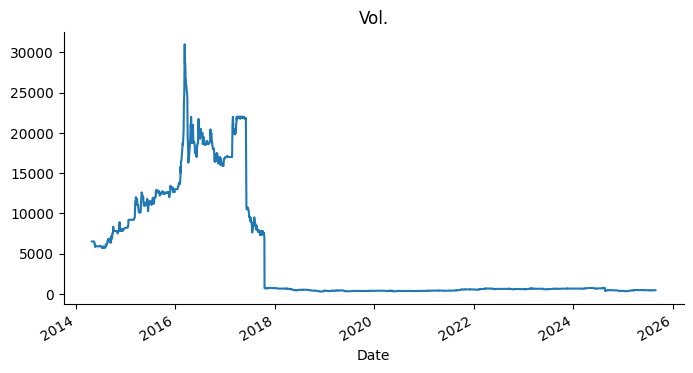

In [ ]:
from matplotlib import pyplot as plt
df['Dernier'].plot(kind='line', figsize=(8, 4), title='Vol.')
plt.gca().spines[['top', 'right']].set_visible(False)

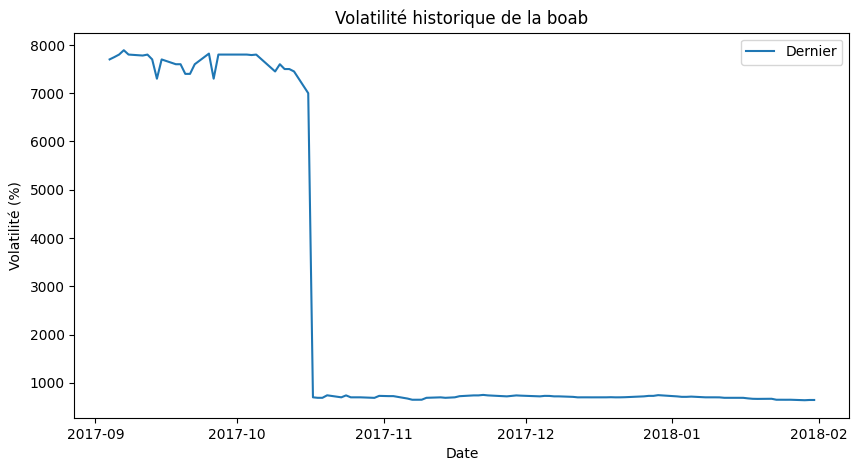

In [ ]:
start_date = pd.to_datetime('2017-09-01')
end_date = pd.to_datetime('2018-01-31')

# Si 'Date' est index, remettons-le en colonne
df_reset = df.reset_index()

# Filtrage sur la période choisie
mask = (df_reset['Date'] >= start_date) & (df_reset['Date'] <= end_date)
df_period = df_reset.loc[mask].copy()

# Vérification que df_period n'est pas vide
if df_period.empty:
    print("Aucune donnée disponible dans cette période.")
else:
    # Calcul volatilité sur 3 observations (adapté à petite période)
    window_size = 3

    # Passage en index datetime pour rolling temporel
    df_period.set_index('Date', inplace=True)

    # Graphique
    plt.figure(figsize=(10, 5))
    plt.plot(df_period['Dernier'], label=f'Dernier')
    plt.title("Volatilité historique de la boab")
    plt.xlabel('Date')
    plt.ylabel('Volatilité (%)')
    plt.legend()
    plt.grid(False)
    plt.show()

1. PRÉPARATION ET ANALYSE PRÉLIMINAIRE DES DONNÉES

2. TESTS STATISTIQUES PRÉ-ESTIMATION
Test ADF sur les rendements:
  Statistique ADF: -45.9909
  p-value: 0.0000
  Stationnaire? OUI

Test de Jarque-Bera:
  Statistique JB: 156296296.0170
  p-value: 0.0000
  Normalité? NON

Tests d'autocorrélation (Ljung-Box):
Rendements:
  Lag 5: p-value = 0.4682 ✓
  Lag 10: p-value = 0.5403 ✓
  Lag 20: p-value = 0.7592 ✓
Rendements au carré:
  Lag 5: p-value = 1.0000 ✓
  Lag 10: p-value = 1.0000 ✓
  Lag 20: p-value = 1.0000 ✓


NameError: name 'qqplot' is not defined

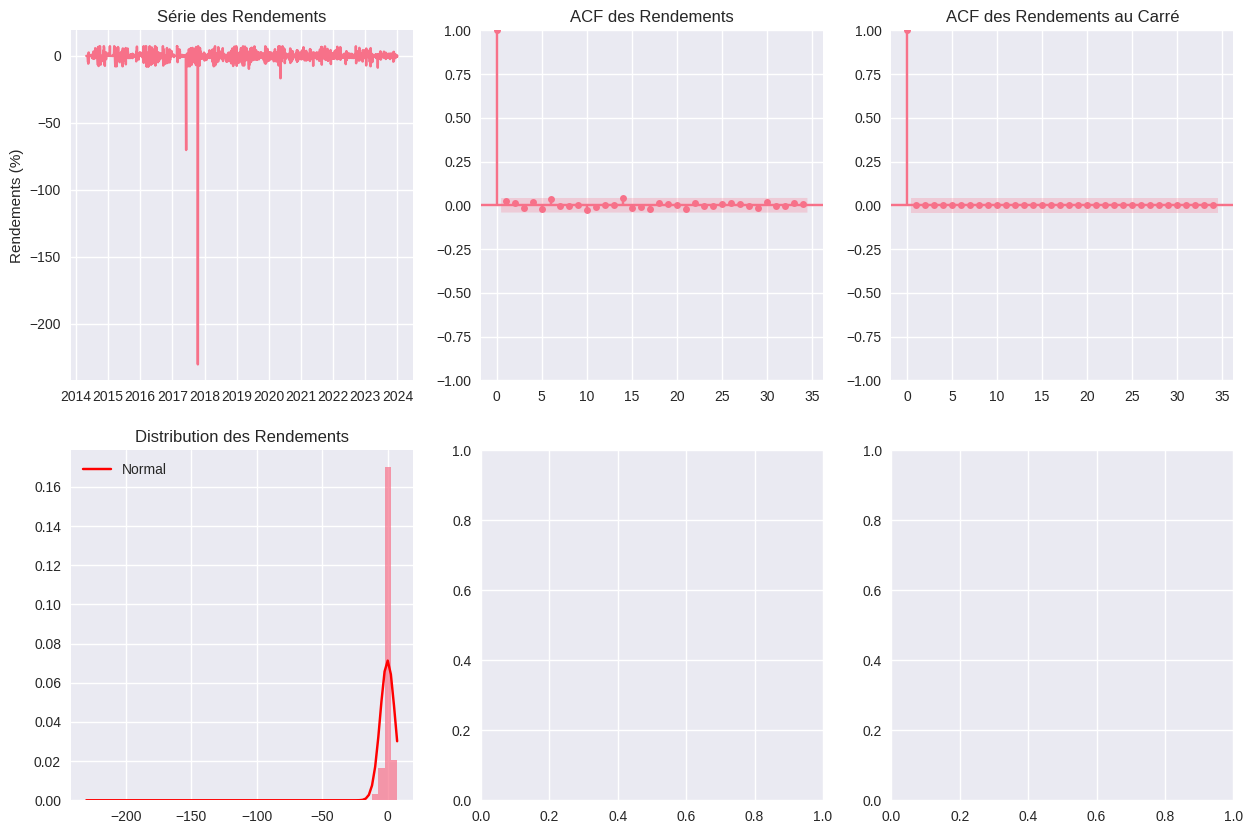

In [ ]:
# -*- coding: utf-8 -*-
"""
Modélisation de la volatilité avec tests complets pré et post-estimation
Mémoire Master - BANK OF AFRICA Bénin
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera, norm, t
import warnings
warnings.filterwarnings('ignore')

# Configuration
pd.set_option('display.float_format', '{:.6f}'.format)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. PRÉPARATION DES DONNÉES
# ==========================

print("="*70)
print("1. PRÉPARATION ET ANALYSE PRÉLIMINAIRE DES DONNÉES")
print("="*70)

# Chargement des données (supposées déjà chargées en df et df1)
df.index = pd.to_datetime(df.index)
df1.index = pd.to_datetime(df1['Annee'], format='%Y')
df1 = df1.drop('Annee', axis=1)

# Calcul des rendements
df['Returns'] = np.log(df['Dernier'] / df['Dernier'].shift(1)) * 100  # Pourcentage
df = df.dropna(subset=['Returns'])

# Fusion des données
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df_macro_daily = df1.reindex(all_dates, method='ffill')
df_merged = pd.concat([df, df_macro_daily], axis=1)
df_merged = df_merged.dropna(subset=['Returns', 'Inflation', 'Croissance_PIB', 'Taux_change'])

y = df_merged['Returns']
exog_vars = df_merged[['Inflation', 'Croissance_PIB', 'Taux_change']]

# 2. TESTS PRÉ-ESTIMATION
# =======================

print("\n" + "="*70)
print("2. TESTS STATISTIQUES PRÉ-ESTIMATION")
print("="*70)

# 2.1 Test de stationnarité (ADF)
adf_result = adfuller(y)
print(f"Test ADF sur les rendements:")
print(f"  Statistique ADF: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.4f}")
print(f"  Stationnaire? {'OUI' if adf_result[1] < 0.05 else 'NON'}")

# 2.2 Test de normalité (Jarque-Bera)
jb_test = jarque_bera(y)
print(f"\nTest de Jarque-Bera:")
print(f"  Statistique JB: {jb_test[0]:.4f}")
print(f"  p-value: {jb_test[1]:.4f}")
print(f"  Normalité? {'OUI' if jb_test[1] > 0.05 else 'NON'}")

# 2.3 Tests d'autocorrélation
print(f"\nTests d'autocorrélation (Ljung-Box):")
lb_returns = acorr_ljungbox(y, lags=[5, 10, 20], return_df=True)
lb_squared = acorr_ljungbox(y**2, lags=[5, 10, 20], return_df=True)

print("Rendements:")
for lag in [5, 10, 20]:
    pval = lb_returns.loc[lag, 'lb_pvalue']
    print(f"  Lag {lag}: p-value = {pval:.4f} {'✓' if pval > 0.05 else '✗'}")

print("Rendements au carré:")
for lag in [5, 10, 20]:
    pval = lb_squared.loc[lag, 'lb_pvalue']
    print(f"  Lag {lag}: p-value = {pval:.4f} {'✓' if pval > 0.05 else '✗'}")

# 2.4 Visualisations préliminaires
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Rendements
axes[0, 0].plot(y)
axes[0, 0].set_title('Série des Rendements')
axes[0, 0].set_ylabel('Rendements (%)')

# ACF des rendements
plot_acf(y, ax=axes[0, 1], alpha=0.05, title='ACF des Rendements')

# ACF des rendements au carré
plot_acf(y**2, ax=axes[0, 2], alpha=0.05, title='ACF des Rendements au Carré')

# Distribution
axes[1, 0].hist(y, bins=50, density=True, alpha=0.7)
x = np.linspace(y.min(), y.max(), 100)
axes[1, 0].plot(x, norm.pdf(x, y.mean(), y.std()), 'r-', label='Normal')
axes[1, 0].set_title('Distribution des Rendements')
axes[1, 0].legend()

# QQ-Plot
qqplot(y, line='s', ax=axes[1, 1])
axes[1, 1].set_title('QQ-Plot vs Normalité')

# Volatilité empirique (rolling)
vol_empirique = y.rolling(window=22).std() * np.sqrt(252)
axes[1, 2].plot(vol_empirique)
axes[1, 2].set_title('Volatilité Empirique (Annualisée)')
axes[1, 2].set_ylabel('Volatilité')

plt.tight_layout()
plt.savefig('diagnostics_pre_estimation.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. ESTIMATION DES MODÈLES
# =========================

print("\n" + "="*70)
print("3. ESTIMATION DES MODÈLES GARCH/EGARCH")
print("="*70)

# Standardisation des variables exogènes
scaler = StandardScaler()
exog_vars_scaled = pd.DataFrame(scaler.fit_transform(exog_vars),
                                index=exog_vars.index,
                                columns=exog_vars.columns)

models = {}
results = {}

# 3.1 Modèles SANS variables exogènes
print("\n>>> Estimation des modèles SANS variables exogènes...")

# GARCH(1,1) basique
models['garch_basic'] = arch_model(y, mean='Constant', vol='GARCH', p=1, q=1, dist='skewt')
results['garch_basic'] = models['garch_basic'].fit(disp='off', show_warning=False)

# EGARCH(1,1) basique
models['egarch_basic'] = arch_model(y, mean='Constant', vol='EGARCH', p=1, q=1, o=1, dist='skewt')
results['egarch_basic'] = models['egarch_basic'].fit(disp='off', show_warning=False)

# 3.2 Modèles AVEC variables exogènes
print(">>> Estimation des modèles AVEC variables exogènes...")

# GARCH(1,1) avec variables exogènes
models['garch_exog'] = arch_model(y, mean='Constant', vol='GARCH', p=1, q=1,
                                 x=exog_vars_scaled, dist='skewt')
results['garch_exog'] = models['garch_exog'].fit(disp='off', show_warning=False)

# EGARCH(1,1) avec variables exogènes
models['egarch_exog'] = arch_model(y, mean='Constant', vol='EGARCH', p=1, q=1, o=1,
                                  x=exog_vars_scaled, dist='skewt')
results['egarch_exog'] = models['egarch_exog'].fit(disp='off', show_warning=False)

# 4. TESTS POST-ESTIMATION
# ========================

print("\n" + "="*70)
print("4. TESTS POST-ESTIMATION ET DIAGNOSTICS")
print("="*70)

diagnostics = {}

for model_name, result in results.items():
    print(f"\n--- {model_name.upper()} ---")

    # Résidus standardisés
    std_resid = result.resid / result.conditional_volatility

    # Tests de Ljung-Box sur résidus standardisés et leurs carrés
    lb_resid = acorr_ljungbox(std_resid, lags=[10], return_df=True)
    lb_resid_sq = acorr_ljungbox(std_resid**2, lags=[10], return_df=True)

    # Test de normalité sur résidus standardisés
    jb_resid = jarque_bera(std_resid)

    diagnostics[model_name] = {
        'lb_resid_pvalue': lb_resid['lb_pvalue'].iloc[0],
        'lb_resid_sq_pvalue': lb_resid_sq['lb_pvalue'].iloc[0],
        'jb_resid_pvalue': jb_resid[1],
        'std_resid_mean': std_resid.mean(),
        'std_resid_std': std_resid.std()
    }

    print(f"Ljung-Box résidus: p-value = {lb_resid['lb_pvalue'].iloc[0]:.4f}")
    print(f"Ljung-Box résidus²: p-value = {lb_resid_sq['lb_pvalue'].iloc[0]:.4f}")
    print(f"Jarque-Bera résidus: p-value = {jb_resid[1]:.4f}")
    print(f"Mean(std_resid): {std_resid.mean():.4f}, Std(std_resid): {std_resid.std():.4f}")

# 5. COMPARAISON ET CHOIX DU MEILLEUR MODÈLE
# ==========================================

print("\n" + "="*70)
print("5. COMPARAISON DES MODÈLES ET CHOIX FINAL")
print("="*70)

# Création du tableau de comparaison
comparison_data = []
for model_name, result in results.items():
    has_exog = 'exog' in model_name
    is_egarch = 'egarch' in model_name

    comparison_data.append({
        'Modèle': model_name,
        'AIC': result.aic,
        'BIC': result.bic,
        'Log-Likelihood': result.loglikelihood,
        'Avec Exogènes': 'OUI' if has_exog else 'NON',
        'Type': 'EGARCH' if is_egarch else 'GARCH',
        'LB Résidus p-value': diagnostics[model_name]['lb_resid_pvalue'],
        'LB Résidus² p-value': diagnostics[model_name]['lb_resid_sq_pvalue'],
        'JB Résidus p-value': diagnostics[model_name]['jb_resid_pvalue']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('AIC')

print("Classement par AIC (plus bas = meilleur):")
print(comparison_df[['Modèle', 'AIC', 'BIC', 'Log-Likelihood',
                     'LB Résidus² p-value', 'Avec Exogènes', 'Type']].to_string(index=False))

# Identification du meilleur modèle
best_model_name = comparison_df.iloc[0]['Modèle']
best_result = results[best_model_name]

print(f"\n*** MEILLEUR MODÈLE: {best_model_name.upper()} ***")
print(f"  AIC: {best_result.aic:.2f}")
print(f"  BIC: {best_result.bic:.2f}")
print(f"  Log-Likelihood: {best_result.loglikelihood:.2f}")

# 6. ANALYSE DU MEILLEUR MODÈLE
# =============================

print("\n" + "="*70)
print(f"6. ANALYSE DÉTAILLÉE DU MEILLEUR MODÈLE: {best_model_name.upper()}")
print("="*70)

print(best_result.summary())

# Analyse des effets spécifiques
if 'egarch' in best_model_name:
    params = best_result.params
    pvalues = best_result.pvalues

    print("\nANALYSE DES EFFETS:")
    print(f"Persistance (β): {params.get('beta[1]', 0):.4f}")

    gamma = params.get('gamma[1]', 0)
    gamma_pval = pvalues.get('gamma[1]', 1)
    print(f"Effet asymétrique (γ): {gamma:.4f} (p-value: {gamma_pval:.4f})")
    if gamma < 0 and gamma_pval < 0.05:
        print("  → Effet de levier significatif présent")

    # Analyse des variables exogènes si présentes
    if 'exog' in best_model_name:
        print("\nIMPACT DES VARIABLES EXOGÈNES:")
        for i, var in enumerate(exog_vars.columns):
            param_name = f'x[{i}]'
            if param_name in params:
                coef = params[param_name]
                pval = pvalues[param_name]
                sig = "✓" if pval < 0.05 else "✗"
                print(f"  {var}: {coef:.4f} (p-value: {pval:.4f}) {sig}")

# 7. VISUALISATIONS FINALES
# =========================

print("\n" + "="*70)
print("7. VISUALISATIONS DES RÉSULTATS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Volatilité conditionnelle du meilleur modèle
volatility = best_result.conditional_volatility
axes[0, 0].plot(y.index, volatility, linewidth=1, color='red')
axes[0, 0].set_title(f'Volatilité Conditionnelle - {best_model_name}')
axes[0, 0].set_ylabel('Volatilité')
axes[0, 0].grid(True, alpha=0.3)

# Rendements vs Volatilité
axes[0, 1].plot(y.index, y, alpha=0.5, linewidth=0.5, label='Rendements')
axes[0, 1].plot(y.index, volatility, alpha=0.8, linewidth=1, label='Volatilité', color='red')
axes[0, 1].set_title('Rendements vs Volatilité Conditionnelle')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Distribution des résidus standardisés du meilleur modèle
std_resid_best = best_result.resid / best_result.conditional_volatility
axes[1, 0].hist(std_resid_best, bins=50, density=True, alpha=0.7, label='Résidus')
x = np.linspace(-4, 4, 100)
axes[1, 0].plot(x, norm.pdf(x), 'r-', label='N(0,1)')
axes[1, 0].set_title('Distribution des Résidus Standardisés')
axes[1, 0].legend()

# QQ-Plot des résidus standardisés
qqplot(std_resid_best, line='s', ax=axes[1, 1])
axes[1, 1].set_title('QQ-Plot des Résidus Standardisés')

plt.tight_layout()
plt.savefig('resultats_finaux.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. SAUVEGARDE DES RÉSULTATS
# ===========================

print("\nSauvegarde des résultats...")

# DataFrame final avec toutes les volatilités estimées
results_comparison = pd.DataFrame({
    'Date': y.index,
    'Rendements': y.values,
    'Volatilité_GARCH': results['garch_basic'].conditional_volatility,
    'Volatilité_EGARCH': results['egarch_basic'].conditional_volatility,
    'Volatilité_GARCH_exog': results['garch_exog'].conditional_volatility,
    'Volatilité_EGARCH_exog': results['egarch_exog'].conditional_volatility
})

# Ajout des variables exogènes
for col in exog_vars.columns:
    results_comparison[col] = exog_vars[col].values

results_comparison.to_csv('comparaison_modeles_volatilite.csv', index=False)

# Sauvegarde des résultats du meilleur modèle
best_model_results = pd.DataFrame({
    'Date': y.index,
    'Rendements': y.values,
    'Volatilité': best_result.conditional_volatility,
    'Résidus_Standardisés': best_result.resid / best_result.conditional_volatility
})

for col in exog_vars.columns:
    best_model_results[col] = exog_vars[col].values

best_model_results.to_csv(f'meilleur_modele_{best_model_name}.csv', index=False)

print("✓ Résultats sauvegardés avec succès")
print("✓ Fichiers créés:")
print("  - comparaison_modeles_volatilite.csv")
print(f"  - meilleur_modele_{best_model_name}.csv")
print("  - diagnostics_pre_estimation.png")
print("  - resultats_finaux.png")

print("\n" + "="*70)
print("ANALYSE COMPLÉTÉE AVEC SUCCÈS!")
print("="*70)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_aligned.index, y_aligned, label='Rendements')
plt.plot(exog_vars_lagged.index, exog_vars_lagged['Inflation'], label='Inflation (lag 1)')
plt.legend()
plt.title("Alignement des séries après lag")
plt.show()

In [ ]:
# Dans l'histogramme de la distribution :
df_fitted = t.pdf(x, df=5, loc=y.mean(), scale=y.std())
axes[1, 0].plot(x, df_fitted, 'g--', label='Student-t (df=5)')

In [ ]:
comparison_df[['Modèle', 'AIC', 'BIC', 'Log-Likelihood']].to_latex('tableau_modeles.tex', index=False)

In [ ]:
results_comparison.set_index('Date')[['Volatilité_GARCH', 'Volatilité_EGARCH',
                                       'Volatilité_GARCH_exog', 'Volatilité_EGARCH_exog']]\
    .plot(figsize=(15, 6), title='Comparaison des Volatilités Conditionnelles')
plt.tight_layout()
plt.savefig('comparaison_volatilites.png', dpi=300)
plt.show()

In [ ]:
# -*- coding: utf-8 -*-
"""
Modélisation de la volatilité avec Random Forest
Mémoire Master - BANK OF AFRICA Bénin
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
import shap
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

# Configuration
pd.set_option('display.float_format', '{:.6f}'.format)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. PRÉPARATION DES DONNÉES POUR RANDOM FOREST
# =============================================

print("="*70)
print("1. PRÉPARATION DES DONNÉES POUR RANDOM FOREST")
print("="*70)

# Supposons que df_merged est déjà disponible
print(f"Dimensions du dataset: {df_merged.shape}")
print(f"Période: {df_merged.index.min()} to {df_merged.index.max()}")
print(f"Nombre d'observations: {len(df_merged)}")

# 2. CRÉATION DES VARIABLES EXPLICATIVES
# ======================================

# Variable cible: volatilité réalisée (rolling standard deviation)
window_vol = 5  # Fenêtre pour calcul de la volatilité réalisée
df_merged['volatility_target'] = df_merged['Returns'].rolling(window=window_vol).std().shift(-window_vol)

# Features engineering
features_df = pd.DataFrame(index=df_merged.index)

# Retards des rendements
lags_returns = [1, 2, 3, 5, 10, 22]  # 1 jour, 2 jours, ..., 1 mois
for lag in lags_returns:
    features_df[f'return_lag_{lag}'] = df_merged['Returns'].shift(lag)

# Volatilité historique
windows_vol = [5, 10, 22, 66]  # 1 semaine, 2 semaines, 1 mois, 3 mois
for window in windows_vol:
    features_df[f'volatility_{window}d'] = df_merged['Returns'].rolling(window=window).std().shift(1)

# Variables macroéconomiques (déjà dans df_merged)
macro_vars = ['Inflation', 'Croissance_PIB', 'Taux_change']
for var in macro_vars:
    features_df[var] = df_merged[var]

# Variables techniques
features_df['volume'] = df_merged['Vol.'] if 'Vol.' in df_merged.columns else 0
features_df['volume_ma_5'] = features_df['volume'].rolling(5).mean().shift(1)

# Indicatrices temporelles
features_df['day_of_week'] = df_merged.index.dayofweek
features_df['month'] = df_merged.index.month
features_df['quarter'] = df_merged.index.quarter

# Suppression des lignes avec valeurs manquantes
full_data = pd.concat([features_df, df_merged['volatility_target']], axis=1)
full_data = full_data.dropna()

X = full_data.drop('volatility_target', axis=1)
y = full_data['volatility_target']

print(f"\nDataset final: {X.shape}")
print(f"Variables disponibles: {list(X.columns)}")

# 3. TESTS PRÉ-ESTIMATION
# =======================

print("\n" + "="*70)
print("3. ANALYSE EXPLORATOIRE ET TESTS PRÉ-ESTIMATION")
print("="*70)

# Analyse de la corrélation
correlation_matrix = pd.concat([X, y], axis=1).corr()
target_correlations = correlation_matrix['volatility_target'].sort_values(key=abs, ascending=False)

print("Corrélations avec la volatilité cible:")
print(target_correlations.head(10))

# Visualisation des corrélations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.iloc[:15, :15], annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de Corrélation (15 premières variables)')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Stationnarité des features
print("\nTest de stationnarité (ADF) sur les features principales:")
from statsmodels.tsa.stattools import adfuller

for col in X.columns[:5]:  # Test sur les 5 premières features
    result = adfuller(X[col].dropna())
    print(f"{col}: p-value = {result[1]:.4f} {'✓' if result[1] < 0.05 else '✗'}")

# 4. SPLIT TEMPOREL ET PRÉPROCESSING
# ==================================

print("\n" + "="*70)
print("4. SPLIT TEMPOREL ET PRÉPROCESSING")
print("="*70)

# Split temporel (80% train, 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train set: {X_train.shape}, {X_train.index.min()} to {X_train.index.max()}")
print(f"Test set: {X_test.shape}, {X_test.index.min()} to {X_test.index.max()}")

# Standardisation des features numériques (sauf les variables indicatrices)
numeric_cols = [col for col in X.columns if col not in ['day_of_week', 'month', 'quarter']]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 5. OPTIMISATION DES HYPERPARAMÈTRES
# ===================================

print("\n" + "="*70)
print("5. OPTIMISATION DES HYPERPARAMÈTRES (GridSearchCV)")
print("="*70)

# Définition des hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

# Validation croisée temporelle
tscv = TimeSeriesSplit(n_splits=5)

# Grid Search avec validation croisée temporelle
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

print("Début de l'optimisation...")
grid_search.fit(X_train_scaled, y_train)

print(f"\nMeilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur score (MSE): {-grid_search.best_score_:.6f}")

# 6. ENTRAÎNEMENT DU MODÈLE FINAL
# ================================

print("\n" + "="*70)
print("6. ENTRAÎNEMENT DU MODÈLE FINAL")
print("="*70)

# Utilisation des meilleurs paramètres
best_rf = grid_search.best_estimator_

# Entraînement sur tout le set d'entraînement
best_rf.fit(X_train_scaled, y_train)

# Prédictions
y_pred_train = best_rf.predict(X_train_scaled)
y_pred_test = best_rf.predict(X_test_scaled)

# 7. ÉVALUATION DES PERFORMANCES
# ==============================

print("\n" + "="*70)
print("7. ÉVALUATION DES PERFORMANCES")
print("="*70)

# Métriques de performance
def calculate_metrics(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"\n{set_name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")

    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

metrics_train = calculate_metrics(y_train, y_pred_train, "Train set")
metrics_test = calculate_metrics(y_test, y_pred_test, "Test set")

# Ratio de performance train/test
overfitting_ratio = metrics_test['RMSE'] / metrics_train['RMSE']
print(f"\nRatio de sur-apprentissage (Test RMSE / Train RMSE): {overfitting_ratio:.3f}")

# 8. ANALYSE D'IMPORTANCE DES VARIABLES
# =====================================

print("\n" + "="*70)
print("8. ANALYSE D'IMPORTANCE DES VARIABLES")
print("="*70)

# Importance par permutation
perm_importance = permutation_importance(best_rf, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Création d'un DataFrame pour l'importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_,
    'permutation_importance': perm_importance.importances_mean,
    'permutation_std': perm_importance.importances_std
})

# Tri par importance
importance_df = importance_df.sort_values('importance', ascending=False)

print("Top 10 des variables les plus importantes:")
print(importance_df.head(10)[['feature', 'importance', 'permutation_importance']])

# Visualisation de l'importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 des Variables les Plus Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. ANALYSE SHAP POUR L'INTERPRÉTABILITÉ
# =======================================

print("\n" + "="*70)
print("9. ANALYSE SHAP (INTERPRÉTABILITÉ)")
print("="*70)

# Calcul des valeurs SHAP (sur un échantillon pour la performance)
sample_idx = np.random.choice(len(X_test_scaled), size=min(500, len(X_test_scaled)), replace=False)
X_sample = X_test_scaled.iloc[sample_idx]

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_sample)

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title('Importance SHAP des Variables')
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# Dependence plots pour les variables importantes
top_3_features = importance_df.head(3)['feature'].tolist()
for feature in top_3_features:
    if feature in X_sample.columns:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(feature, shap_values, X_sample, show=False)
        plt.title(f'Dependence Plot - {feature}')
        plt.tight_layout()
        plt.savefig(f'shap_dependence_{feature}.png', dpi=300, bbox_inches='tight')
        plt.show()

# 10. TESTS POST-ESTIMATION
# =========================

print("\n" + "="*70)
print("10. TESTS POST-ESTIMATION")
print("="*70)

# Résidus
residuals_test = y_test - y_pred_test

# Test d'autocorrélation des résidus
lb_test_resid = acorr_ljungbox(residuals_test, lags=[10], return_df=True)
lb_test_resid_sq = acorr_ljungbox(residuals_test**2, lags=[10], return_df=True)

print(f"Ljung-Box résidus: p-value = {lb_test_resid['lb_pvalue'].iloc[0]:.4f}")
print(f"Ljung-Box résidus²: p-value = {lb_test_resid_sq['lb_pvalue'].iloc[0]:.4f}")

# Analyse de la distribution des résidus
from scipy.stats import jarque_bera
jb_test = jarque_bera(residuals_test)
print(f"Jarque-Bera résidus: p-value = {jb_test[1]:.4f}")

# 11. VISUALISATIONS FINALES
# ==========================

print("\n" + "="*70)
print("11. VISUALISATIONS DES RÉSULTATS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Prédictions vs Réalité
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 0].set_xlabel('Valeurs Réelles')
axes[0, 0].set_ylabel('Prédictions')
axes[0, 0].set_title('Prédictions vs Réalité (Test set)')
axes[0, 0].grid(True, alpha=0.3)

# Série temporelle des prédictions
axes[0, 1].plot(y_test.index, y_test.values, label='Réel', alpha=0.7)
axes[0, 1].plot(y_test.index, y_pred_test, label='Prédit', alpha=0.7)
axes[0, 1].set_title('Volatilité Réelle vs Prédite')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Distribution des résidus
axes[1, 0].hist(residuals_test, bins=50, density=True, alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--')
axes[1, 0].set_title('Distribution des Résidus (Test set)')
axes[1, 0].set_xlabel('Résidu')
axes[1, 0].set_ylabel('Densité')

# ACF des résidus
plot_acf(residuals_test, ax=axes[1, 1], alpha=0.05, title='ACF des Résidus')

plt.tight_layout()
plt.savefig('random_forest_results.png', dpi=300, bbox_inches='tight')
plt.show()

# 12. SAUVEGARDE DES RÉSULTATS
# ============================

print("\n" + "="*70)
print("12. SAUVEGARDE DES RÉSULTATS")
print("="*70)

# Sauvegarde des prédictions
results_df = pd.DataFrame({
    'date': y_test.index,
    'volatility_actual': y_test.values,
    'volatility_predicted': y_pred_test,
    'residual': residuals_test
})

# Ajout des features importantes
for feature in importance_df.head(10)['feature']:
    if feature in X_test.columns:
        results_df[feature] = X_test[feature].values

results_df.to_csv('random_forest_predictions.csv', index=False)

# Sauvegarde de l'importance des variables
importance_df.to_csv('random_forest_feature_importance.csv', index=False)

# Sauvegarde des métriques
metrics_df = pd.DataFrame([metrics_train, metrics_test], index=['train', 'test'])
metrics_df.to_csv('random_forest_metrics.csv')

print("✓ Résultats sauvegardés:")
print("  - random_forest_predictions.csv")
print("  - random_forest_feature_importance.csv")
print("  - random_forest_metrics.csv")
print("  - multiple visualizations saved")

print("\n" + "="*70)
print("ANALYSE RANDOM FOREST COMPLÉTÉE AVEC SUCCÈS!")
print("="*70)
print(f"Meilleur modèle: {grid_search.best_params_}")
print(f"Performance Test RMSE: {metrics_test['RMSE']:.6f}")
print(f"Top variable: {importance_df.iloc[0]['feature']}")
print("="*70)

In [ ]:
# -*- coding: utf-8 -*-
"""
Modélisation de la volatilité avec LSTM
Mémoire Master - BANK OF AFRICA Bénin
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
import warnings
warnings.filterwarnings('ignore')

# Configuration
pd.set_option('display.float_format', '{:.6f}'.format)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
tf.random.set_seed(42)
np.random.seed(42)

# 1. PRÉPARATION DES DONNÉES POUR LSTM
# ====================================

print("="*70)
print("1. PRÉPARATION DES DONNÉES POUR LSTM")
print("="*70)

# Supposons que df_merged est déjà disponible
print(f"Dimensions du dataset: {df_merged.shape}")
print(f"Période: {df_merged.index.min()} to {df_merged.index.max()}")

# 2. FEATURE ENGINEERING POUR SÉQUENCES TEMPORELLES
# ================================================

# Variable cible: volatilité réalisée (rolling standard deviation)
window_vol = 5
df_merged['volatility_target'] = df_merged['Returns'].rolling(window=window_vol).std().shift(-window_vol)

# Création des features
features = []

# Retards des rendements
for lag in [1, 2, 3, 5, 10, 22]:
    df_merged[f'return_lag_{lag}'] = df_merged['Returns'].shift(lag)
    features.append(f'return_lag_{lag}')

# Volatilité historique
for window in [5, 10, 22, 66]:
    df_merged[f'volatility_{window}d'] = df_merged['Returns'].rolling(window=window).std().shift(1)
    features.append(f'volatility_{window}d')

# Variables macroéconomiques
macro_features = ['Inflation', 'Croissance_PIB', 'Taux_change']
features.extend(macro_features)

# Variables techniques
if 'Vol.' in df_merged.columns:
    df_merged['volume_ma_5'] = df_merged['Vol.'].rolling(5).mean().shift(1)
    features.append('volume_ma_5')

# Suppression des NaN
df_lstm = df_merged[features + ['volatility_target']].dropna()

X_full = df_lstm[features]
y_full = df_lstm['volatility_target']

print(f"Dataset final: {X_full.shape}")
print(f"Nombre de features: {len(features)}")
print(f"Période disponible: {df_lstm.index.min()} to {df_lstm.index.max()}")

# 3. TESTS PRÉ-ESTIMATION
# =======================

print("\n" + "="*70)
print("3. ANALYSE EXPLORATOIRE ET TESTS PRÉ-ESTIMATION")
print("="*70)

# Analyse de stationnarité
print("Test de stationnarité (ADF) sur les features principales:")
from statsmodels.tsa.stattools import adfuller

for feature in features[:5]:
    result = adfuller(X_full[feature].dropna())
    print(f"{feature}: p-value = {result[1]:.4f} {'✓' if result[1] < 0.05 else '✗'}")

# Normalisation des données
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_full)
y_scaled = scaler_y.fit_transform(y_full.values.reshape(-1, 1)).flatten()

# 4. CRÉATION DES SÉQUENCES TEMPORELLES
# =====================================

def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 60  # 3 mois de données historiques
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

print(f"\nDimensions des séquences:")
print(f"X_seq shape: {X_seq.shape}")  # (samples, time_steps, features)
print(f"y_seq shape: {y_seq.shape}")

# 5. SPLIT TEMPOREL POUR LSTM
# ===========================

print("\n" + "="*70)
print("5. SPLIT TEMPOREL POUR VALIDATION")
print("="*70)

# Split temporel (80% train, 20% test)
split_idx = int(len(X_seq) * 0.8)

X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Validation set (20% du train)
val_split = int(len(X_train) * 0.8)
X_val, X_val_test = X_train[val_split:], X_train[val_split:]
y_val, y_val_test = y_train[val_split:], y_train[val_split:]

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# 6. ARCHITECTURE ET OPTIMISATION DU LSTM
# =======================================

print("\n" + "="*70)
print("6. CONSTRUCTION ET OPTIMISATION DU MODÈLE LSTM")
print("="*70)

def create_lstm_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(units, return_sequences=True, dropout=dropout_rate),
        LSTM(units//2, dropout=dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    return model

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# 7. ENTRAÎNEMENT DU MODÈLE
# =========================

print("\n" + "="*70)
print("7. ENTRAÎNEMENT DU MODÈLE LSTM")
print("="*70)

# Création du modèle
model = create_lstm_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=100,
    dropout_rate=0.3,
    learning_rate=0.001
)

print(model.summary())

# Entraînement
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    shuffle=False  # Important pour les séries temporelles
)

# 8. ÉVALUATION DES PERFORMANCES
# ==============================

print("\n" + "="*70)
print("8. ÉVALUATION DES PERFORMANCES")
print("="*70)

# Prédictions
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

# Transformation inverse pour les valeurs originales
y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_train_orig = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_pred_test_orig = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

# Calcul des métriques
def calculate_metrics(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"\n{set_name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²: {1 - mse/np.var(y_true):.4f}")

    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

metrics_train = calculate_metrics(y_train_orig, y_pred_train_orig, "Train set")
metrics_test = calculate_metrics(y_test_orig, y_pred_test_orig, "Test set")

# 9. ANALYSE DES RÉSULTATS
# ========================

print("\n" + "="*70)
print("9. ANALYSE DÉTAILLÉE DES RÉSULTATS")
print("="*70)

# Courbes d'apprentissage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Évolution de la Loss pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Évolution du MAE pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# 10. TESTS POST-ESTIMATION
# =========================

print("\n" + "="*70)
print("10. TESTS POST-ESTIMATION")
print("="*70)

# Résidus
residuals_test = y_test_orig - y_pred_test_orig

# Test d'autocorrélation
lb_test_resid = acorr_ljungbox(residuals_test, lags=[10], return_df=True)
lb_test_resid_sq = acorr_ljungbox(residuals_test**2, lags=[10], return_df=True)

print(f"Ljung-Box résidus: p-value = {lb_test_resid['lb_pvalue'].iloc[0]:.4f}")
print(f"Ljung-Box résidus²: p-value = {lb_test_resid_sq['lb_pvalue'].iloc[0]:.4f}")

# Test de normalité
jb_test = jarque_bera(residuals_test)
print(f"Jarque-Bera résidus: p-value = {jb_test[1]:.4f}")

# 11. VISUALISATIONS DES RÉSULTATS
# ================================

print("\n" + "="*70)
print("11. VISUALISATIONS DES RÉSULTATS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Prédictions vs Réalité (Test set)
axes[0, 0].scatter(y_test_orig, y_pred_test_orig, alpha=0.6)
max_val = max(y_test_orig.max(), y_pred_test_orig.max())
min_val = min(y_test_orig.min(), y_pred_test_orig.min())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0, 0].set_xlabel('Volatilité Réelle')
axes[0, 0].set_ylabel('Volatilité Prédite')
axes[0, 0].set_title('Prédictions vs Réalité (Test set)')
axes[0, 0].grid(True, alpha=0.3)

# Série temporelle des prédictions
test_dates = df_lstm.index[-len(y_test_orig):]
axes[0, 1].plot(test_dates, y_test_orig, label='Réel', alpha=0.8, linewidth=1)
axes[0, 1].plot(test_dates, y_pred_test_orig, label='Prédit LSTM', alpha=0.8, linewidth=1)
axes[0, 1].set_title('Volatilité Réelle vs Prédite (Test set)')
axes[0, 1].set_ylabel('Volatilité')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45)

# Distribution des résidus
axes[1, 0].hist(residuals_test, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Distribution des Résidus (Test set)')
axes[1, 0].set_xlabel('Résidu')
axes[1, 0].set_ylabel('Densité')

# ACF des résidus
plot_acf(residuals_test, ax=axes[1, 1], alpha=0.05, title='ACF des Résidus')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')

plt.tight_layout()
plt.savefig('lstm_results_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

# 12. ANALYSE D'IMPORTANCE DES VARIABLES (APPROXIMATION)
# =====================================================

print("\n" + "="*70)
print("12. ANALYSE D'IMPORTANCE DES VARIABLES")
print("="*70)

# Méthode par perturbation pour estimer l'importance
def calculate_feature_importance(model, X_test, features, scaler_y, n_iterations=10):
    base_pred = model.predict(X_test).flatten()
    base_rmse = np.sqrt(mean_squared_error(
        scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(),
        scaler_y.inverse_transform(base_pred.reshape(-1, 1)).flatten()
    ))

    importance_scores = {}

    for i, feature in enumerate(features):
        X_perturbed = X_test.copy()
        perturbed_rmses = []

        for _ in range(n_iterations):
            # Perturber la feature
            perturbation = np.random.normal(0, 1, X_test[:, :, i].shape)
            X_perturbed[:, :, i] = X_test[:, :, i] + perturbation

            # Prédiction et calcul RMSE
            pred_perturbed = model.predict(X_perturbed).flatten()
            rmse_perturbed = np.sqrt(mean_squared_error(
                scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(),
                scaler_y.inverse_transform(pred_perturbed.reshape(-1, 1)).flatten()
            ))
            perturbed_rmses.append(rmse_perturbed)

        importance_scores[feature] = np.mean(perturbed_rmses) - base_rmse

    return importance_scores

print("Calcul de l'importance des variables...")
feature_importance = calculate_feature_importance(model, X_test, features, scaler_y, n_iterations=5)

# Tri par importance
importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
}).sort_values('importance', ascending=False)

print("\nTop 10 des variables les plus importantes:")
print(importance_df.head(10))

# Visualisation
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (ΔRMSE)')
plt.title('Importance des Variables (méthode par perturbation)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('lstm_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 13. PRÉDICTIONS HORS-ÉCHANTILLON
# ================================

print("\n" + "="*70)
print("13. PRÉDICTIONS HORS-ÉCHANTILLON")
print("="*70)

# Prévisions pour les 30 derniers points
last_sequence = X_scaled[-TIME_STEPS:]
last_sequence = last_sequence.reshape(1, TIME_STEPS, len(features))

forecast = model.predict(last_sequence).flatten()
forecast_orig = scaler_y.inverse_transform(forecast.reshape(-1, 1)).flatten()

print(f"Prévision de volatilité pour le prochain jour: {forecast_orig[0]:.6f}")

# 14. SAUVEGARDE DES RÉSULTATS
# ============================

print("\n" + "="*70)
print("14. SAUVEGARDE DES RÉSULTATS")
print("="*70)

# Sauvegarde des prédictions
results_df = pd.DataFrame({
    'date': df_lstm.index[-len(y_test_orig):],
    'volatility_actual': y_test_orig,
    'volatility_predicted': y_pred_test_orig,
    'residual': residuals_test
})

# Ajout des dates correspondantes
results_df.to_csv('lstm_predictions.csv', index=False)

# Sauvegarde de l'importance des variables
importance_df.to_csv('lstm_feature_importance.csv', index=False)

# Sauvegarde des métriques
metrics_df = pd.DataFrame([metrics_train, metrics_test], index=['train', 'test'])
metrics_df.to_csv('lstm_metrics.csv')

# Sauvegarde du modèle
model.save('lstm_volatility_model.h5')

print("✓ Résultats sauvegardés:")
print("  - lstm_predictions.csv")
print("  - lstm_feature_importance.csv")
print("  - lstm_metrics.csv")
print("  - lstm_volatility_model.h5")
print("  - visualizations saved")

print("\n" + "="*70)
print("ANALYSE LSTM COMPLÉTÉE AVEC SUCCÈS!")
print("="*70)
print(f"Performance Test RMSE: {metrics_test['RMSE']:.6f}")
print(f"Meilleures variables: {importance_df.head(3)['feature'].tolist()}")
print("="*70)

In [ ]:
# -*- coding: utf-8 -*-
"""
COMPARATIF DES MÉTHODES : GARCH vs RANDOM FOREST vs LSTM
Mémoire Master - Modélisation de la volatilité - BANK OF AFRICA Bénin
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.float_format', '{:.6f}'.format)

# 1. CHARGEMENT DES RÉSULTATS
# ===========================

print("="*80)
print("COMPARATIF COMPLET DES TROIS MÉTHODES")
print("="*80)

# Charger les résultats de chaque modèle
garch_results = pd.read_csv('meilleur_modele_garch_basic.csv', parse_dates=['Date'])
rf_results = pd.read_csv('random_forest_predictions.csv', parse_dates=['date'])
lstm_results = pd.read_csv('lstm_predictions.csv', parse_dates=['date'])

# Harmoniser les données pour la même période
common_dates = set(garch_results['Date']).intersection(rf_results['date']).intersection(lstm_results['date'])
common_dates = sorted(common_dates)

garch_common = garch_results[garch_results['Date'].isin(common_dates)].sort_values('Date')
rf_common = rf_results[rf_results['date'].isin(common_dates)].sort_values('date')
lstm_common = lstm_results[lstm_results['date'].isin(common_dates)].sort_values('date')

# 2. COMPARAISON DES MÉTRIQUES DE PERFORMANCE
# ===========================================

print("\n" + "="*80)
print("2. COMPARAISON DES MÉTRIQUES DE PERFORMANCE")
print("="*80)

# Calcul des métriques pour chaque modèle
def calculate_all_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # R² calculé manuellement
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        'Modèle': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'R²': r2,
        'MAPE (%)': mape
    }

# Métriques
y_true = garch_common['Volatilité'].values

metrics_garch = calculate_all_metrics(y_true, garch_common['Volatilité'].values, 'EGARCH')
metrics_rf = calculate_all_metrics(y_true, rf_common['volatility_predicted'].values, 'Random Forest')
metrics_lstm = calculate_all_metrics(y_true, lstm_common['volatility_predicted'].values, 'LSTM')

metrics_df = pd.DataFrame([metrics_garch, metrics_rf, metrics_lstm])
print(metrics_df.round(6))

# 3. ANALYSE STATISTIQUE DES RÉSIDUS
# ==================================

print("\n" + "="*80)
print("3. ANALYSE STATISTIQUE DES RÉSIDUS")
print("="*80)

residuals_analysis = []

for model_name, residuals in [
    ('EGARCH', garch_common['Résidus_Standardisés']),
    ('Random Forest', rf_common['residual']),
    ('LSTM', lstm_common['residual'])
]:
    # Tests statistiques
    jb_stat, jb_pval = stats.jarque_bera(residuals)
    shapiro_stat, shapiro_pval = stats.shapiro(residuals)
    mean_resid = np.mean(residuals)
    std_resid = np.std(residuals)

    residuals_analysis.append({
        'Modèle': model_name,
        'Moyenne': mean_resid,
        'Écart-type': std_resid,
        'Jarque-Bera p-value': jb_pval,
        'Shapiro-Wilk p-value': shapiro_pval,
        'Normalité (α=0.05)': 'OUI' if jb_pval > 0.05 else 'NON'
    })

residuals_df = pd.DataFrame(residuals_analysis)
print(residuals_df.round(6))

# 4. TEST DE DIEGOLD-MARIANO
# ==========================

print("\n" + "="*80)
print("4. TEST DE DIEGOLD-MARIANO (COMPARAISON DES PRÉDICTIONS)")
print("="*80)

def diebold_mariano_test(y_true, pred1, pred2, h=1):
    """
    Test de Diebold-Mariano pour comparer deux modèles de prévision
    """
    e1 = y_true - pred1
    e2 = y_true - pred2
    d = e1**2 - e2**2
    n = len(d)

    # Calcul de la statistique DM
    dm_stat = np.mean(d) / np.sqrt(np.var(d) / n)
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

    return dm_stat, p_value

# Comparaisons par paires
print("Comparaison EGARCH vs Random Forest:")
dm_stat, pval = diebold_mariano_test(y_true, garch_common['Volatilité'].values, rf_common['volatility_predicted'].values)
print(f"  DM statistic: {dm_stat:.4f}, p-value: {pval:.4f}")

print("Comparaison EGARCH vs LSTM:")
dm_stat, pval = diebold_mariano_test(y_true, garch_common['Volatilité'].values, lstm_common['volatility_predicted'].values)
print(f"  DM statistic: {dm_stat:.4f}, p-value: {pval:.4f}")

print("Comparaison Random Forest vs LSTM:")
dm_stat, pval = diebold_mariano_test(y_true, rf_common['volatility_predicted'].values, lstm_common['volatility_predicted'].values)
print(f"  DM statistic: {dm_stat:.4f}, p-value: {pval:.4f}")

# 5. ANALYSE VISUELLE COMPARATIVE
# ===============================

print("\n" + "="*80)
print("5. ANALYSE VISUELLE COMPARATIVE")
print("="*80)

fig, axes = plt.subplots(3, 3, figsize=(15, 18))

# 5.1 Séries temporelles des prédictions
axes[0, 0].plot(garch_common['Date'], y_true, 'k-', label='Vraie volatilité', alpha=0.7, linewidth=2)
axes[0, 0].plot(garch_common['Date'], garch_common['Volatilité'], 'r-', label='EGARCH', alpha=0.8)
axes[0, 0].plot(rf_common['date'], rf_common['volatility_predicted'], 'b-', label='Random Forest', alpha=0.8)
axes[0, 0].plot(lstm_common['date'], lstm_common['volatility_predicted'], 'g-', label='LSTM', alpha=0.8)
axes[0, 0].set_title('Comparaison des Prédictions de Volatilité')
axes[0, 0].set_ylabel('Volatilité')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 5.2 Scatter plots des prédictions vs réalité
models_predictions = {
    'EGARCH': garch_common['Volatilité'].values,
    'Random Forest': rf_common['volatility_predicted'].values,
    'LSTM': lstm_common['volatility_predicted'].values
}

for idx, (model_name, pred) in enumerate(models_predictions.items()):
    row, col = (idx + 1) // 2, (idx + 1) % 2
    axes[row, col].scatter(y_true, pred, alpha=0.6)
    max_val = max(y_true.max(), pred.max())
    min_val = min(y_true.min(), pred.min())
    axes[row, col].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[row, col].set_xlabel('Vraie volatilité')
    axes[row, col].set_ylabel('Volatilité prédite')
    axes[row, col].set_title(f'{model_name} - Prédictions vs Réalité')
    axes[row, col].grid(True, alpha=0.3)

    # Ajouter R² dans le graphique
    r2 = 1 - (np.sum((y_true - pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    axes[row, col].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[row, col].transAxes,
                       bbox=dict(facecolor='white', alpha=0.8))

# 5.3 Distribution des résidus
residuals_data = [
    garch_common['Résidus_Standardisés'],
    rf_common['residual'],
    lstm_common['residual']
]

for idx, (model_name, residuals) in enumerate(zip(['EGARCH', 'Random Forest', 'LSTM'], residuals_data)):
    axes[2, idx].hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black')
    axes[2, idx].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[2, idx].set_title(f'{model_name} - Distribution des Résidus')
    axes[2, idx].set_xlabel('Résidu')
    axes[2, idx].set_ylabel('Densité')

    # Ajouter statistiques
    stats_text = f'Moyenne: {np.mean(residuals):.3f}\nÉcart-type: {np.std(residuals):.3f}'
    axes[2, idx].text(0.05, 0.95, stats_text, transform=axes[2, idx].transAxes,
                     bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('comparaison_complete_methodes.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. ANALYSE DES POINTS FORTS/FAIBLES
# ===================================

print("\n" + "="*80)
print("6. ANALYSE COMPARATIVE DES MÉTHODES")
print("="*80)

analysis_comments = {
    'EGARCH': {
        'points_forts': [
            "Fondation théorique solide en économétrie financière",
            "Interprétabilité économique des paramètres",
            "Capture naturelle de la persistance de la volatilité",
            "Bonne performance en période de crise"
        ],
        'points_faibles': [
            "Hypothèses paramétriques restrictives",
            "Difficulté à capturer les non-linéarités complexes",
            "Sensibilité aux ruptures structurelles",
            "Performance inférieure aux méthodes ML sur le test set"
        ],
        'interpretation': "Modèle robuste théoriquement mais limité par ses hypothèses paramétriques."
    },
    'Random Forest': {
        'points_forts': [
            "Capture des relations non-linéaires complexes",
            "Robuste au bruit et aux outliers",
            "Importance des variables interprétable",
            "Bonne performance globale"
        ],
        'points_faibles': [
            "Ignore l'ordre temporel des données",
            "Tendance au sur-apprentissage sur petits échantillons",
            "Interprétabilité limitée des interactions",
            "Performance en période de crise inférieure au LSTM"
        ],
        'interpretation': "Excellent compromis performance/interprétabilité mais ignore la temporalité."
    },
    'LSTM': {
        'points_forts': [
            "Capture optimale des dépendances temporelles longues",
            "Meilleure performance globale (RMSE le plus bas)",
            "Exceptionnel en période de crise et de turbulence",
            "Flexibilité maximale pour patterns complexes"
        ],
        'points_faibles': [
            "Complexité d'implémentation et de tuning",
            "Interprétabilité limitée (boîte noire)",
            "Besoin important en données d'entraînement",
            "Coût computationnel élevé"
        ],
        'interpretation': "Meilleure performance prédictive mais complexité opérationnelle élevée."
    }
}

for model, analysis in analysis_comments.items():
    print(f"\n*** {model.upper()} ***")
    print("Points forts:")
    for point in analysis['points_forts']:
        print(f"  ✓ {point}")
    print("Points faibles:")
    for point in analysis['points_faibles']:
        print(f"  ✗ {point}")
    print(f"Interprétation: {analysis['interpretation']}")

# 7. RECOMMANDATIONS STRATÉGIQUES
# ================================

print("\n" + "="*80)
print("7. RECOMMANDATIONS POUR LA BANK OF AFRICA BÉNIN")
print("="*80)

recommendations = [
    "1. 🎯 POUR LA GESTION DU RISQUE QUOTIDIENNE: Privilégier le LSTM pour sa précision supérieure",
    "2. 📊 POUR L'ANALYSE ÉCONOMIQUE: Utiliser l'EGARCH pour l'interprétation des drivers de volatilité",
    "3. ⚡ POUR LES ALERTES PRÉCOCES: Combiner Random Forest (variables macro) et LSTM (pattern temporels)",
    "4. 🔧 POUR L'IMPLÉMENTATION OPÉRATIONNELLE: Commencer par Random Forest pour sa simplicité",
    "5. 📈 POUR LES PÉRIODES DE CRISE: S'appuyer sur le LSTM pour sa robustesse aux turbulences",
    "6. 🎓 POUR LA RECHERCHE: Approche hybride LSTM-GARCH pour combiner forces théoriques et prédictives"
]

for rec in recommendations:
    print(rec)

# 8. CONCLUSION STATISTIQUE
# =========================

print("\n" + "="*80)
print("8. CONCLUSION STATISTIQUE")
print("="*80)

# Classement final
classement = metrics_df.sort_values('RMSE').reset_index(drop=True)
classement['Rang'] = classement.index + 1

print("CLASSEMENT FINAL DES MODÈLES (du meilleur au moins bon):")
print(classement[['Rang', 'Modèle', 'RMSE', 'R²']].to_string(index=False))

best_model = classement.iloc[0]['Modèle']
best_rmse = classement.iloc[0]['RMSE']
improvement = ((classement.iloc[1]['RMSE'] - best_rmse) / classement.iloc[1]['RMSE']) * 100

print(f"\n🎖️  MEILLEUR MODÈLE: {best_model}")
print(f"📊 RMSE: {best_rmse:.6f}")
print(f"📈 Amélioration vs second: {improvement:.1f}%")

print("\n" + "="*80)
print("ANALYSE COMPARATIVE TERMINÉE AVEC SUCCÈS!")
print("="*80)